In [288]:
# Import pandas that allows us to view and manipulate data
import numpy as np
import pandas as pd
import random

# Import libraries to help us do the modeling
from statsmodels.tsa.stattools import adfuller, acf, pacf, q_stat
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from itertools import product
from sklearn.metrics import mean_squared_error

# Import visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Import warnings and ignore if warnings are shown
import warnings
warnings.filterwarnings('ignore')

In [287]:
import os
os.chdir('C:\\Users\\davia\\OneDrive - Singapore Polytechnic\\SP\\Year 1 Sem 2\\ST15101 (AIML) AI & Machine Learning\\CA2\\Dataset')

In [289]:
df = pd.read_csv('CA2-Stock-Price-Data.csv')

### 1. Data Pre-Processing

#### 1.1 Looking at dataset characteristic

In [290]:
# Finding out the types of data in each column
df.dtypes

Date       object
Apple     float64
Amazon    float64
DBS       float64
dtype: object

In [291]:
df

,Date,Apple,Amazon,DBS
0,10/1/2018,56.814999,100.218002,25.969999
1,10/2/2018,57.320000,98.565498,25.629999
2,10/3/2018,58.017502,97.638000,25.950001
3,10/4/2018,56.997501,95.471001,25.760000
4,10/5/2018,56.072498,94.482498,25.770000
...,...,...,...,...
1252,9/22/2023,174.789993,129.119995,33.250000
1253,9/25/2023,176.080002,131.270004,33.450001
1254,9/26/2023,171.960007,125.980003,33.509998
1255,9/27/2023,170.429993,125.980003,33.430000


#### 1.2 Check for missing dates and values

We need to convert the Date column to a datetime object

In [292]:
df['Date'] = pd.to_datetime(df['Date'])

In [293]:
df.dtypes

Date      datetime64[ns]
Apple            float64
Amazon           float64
DBS              float64
dtype: object

Setting the Date column as the index

In [294]:
df = df.set_index(df['Date']).drop('Date', axis=1)
df

,Apple,Amazon,DBS
Date,,,
2018-10-01,56.814999,100.218002,25.969999
2018-10-02,57.320000,98.565498,25.629999
2018-10-03,58.017502,97.638000,25.950001
2018-10-04,56.997501,95.471001,25.760000
2018-10-05,56.072498,94.482498,25.770000
...,...,...,...
2023-09-22,174.789993,129.119995,33.250000
2023-09-25,176.080002,131.270004,33.450001
2023-09-26,171.960007,125.980003,33.509998


In [295]:
# Get the first and last date of the time series
print('First date', df.index.min())
print('Last date', df.index.max())

First date 2018-10-01 00:00:00
Last date 2023-09-28 00:00:00


In [296]:
# Creating an empty dataset with the date ranges between the start and end of the time series as the index
allDatesDataset = pd.DataFrame(index=pd.date_range(start='2018-10-01', end='2023-09-28'))
df = allDatesDataset.join(df, how='left')

<Axes: >

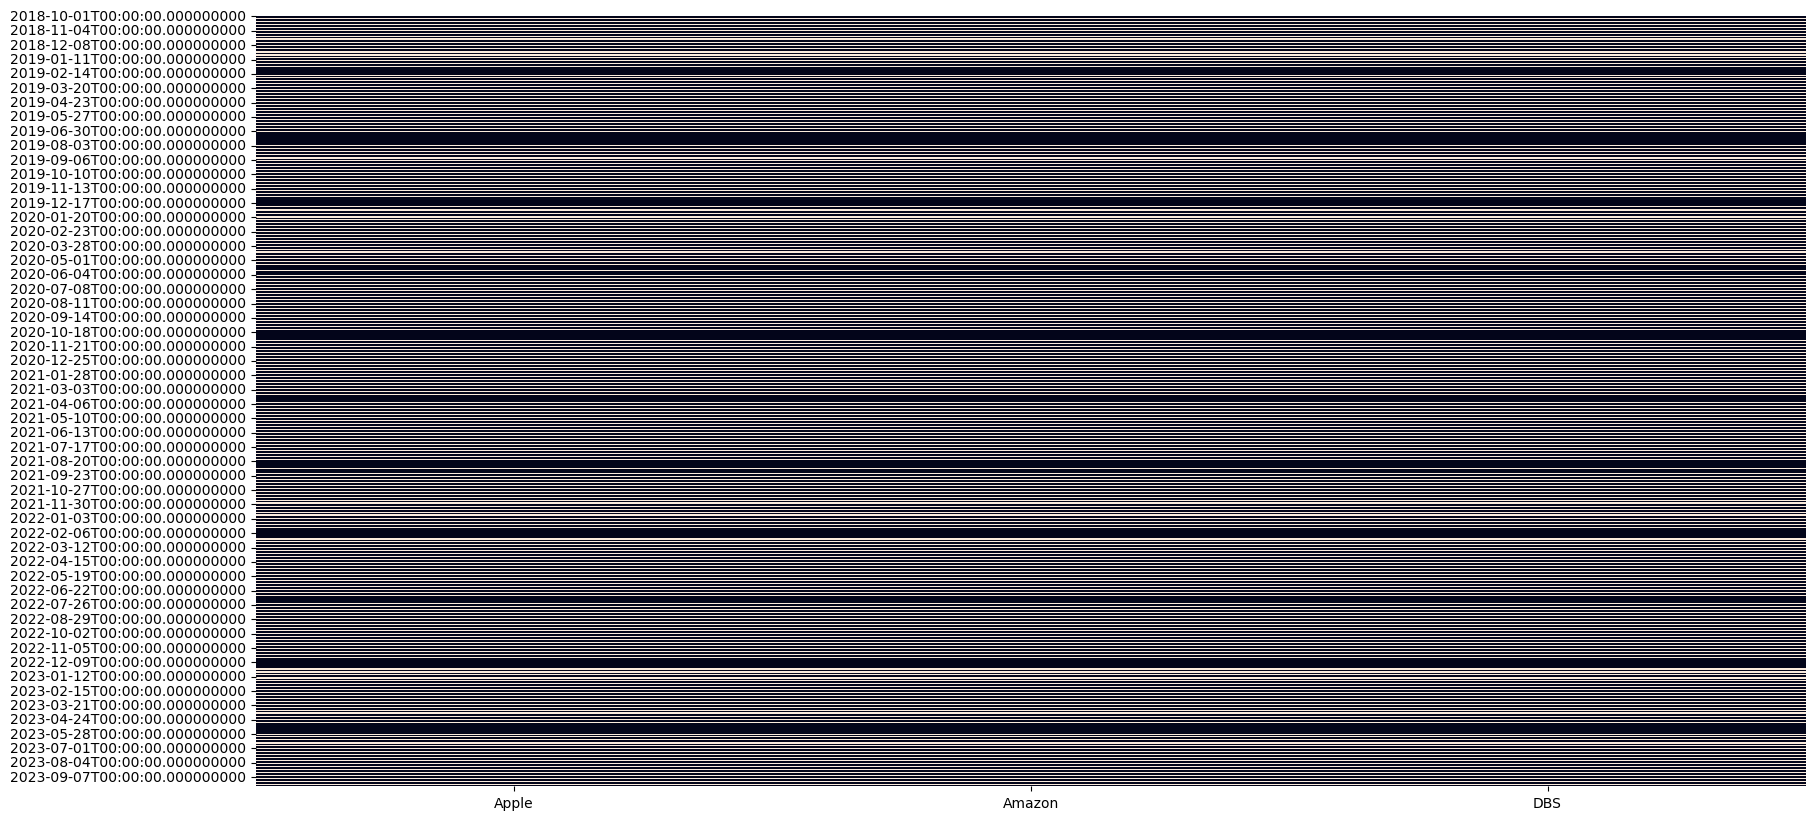

In [297]:
# Print out a heatmap to show how much missing data there is in the dataset
sns.heatmap(df.isnull(), cbar=False)

There are missing data for some dates in the dataset and therefore imputation is needed. To impute I will use the forward fill method.

In [298]:
df = df.fillna(method='ffill')

<Axes: >

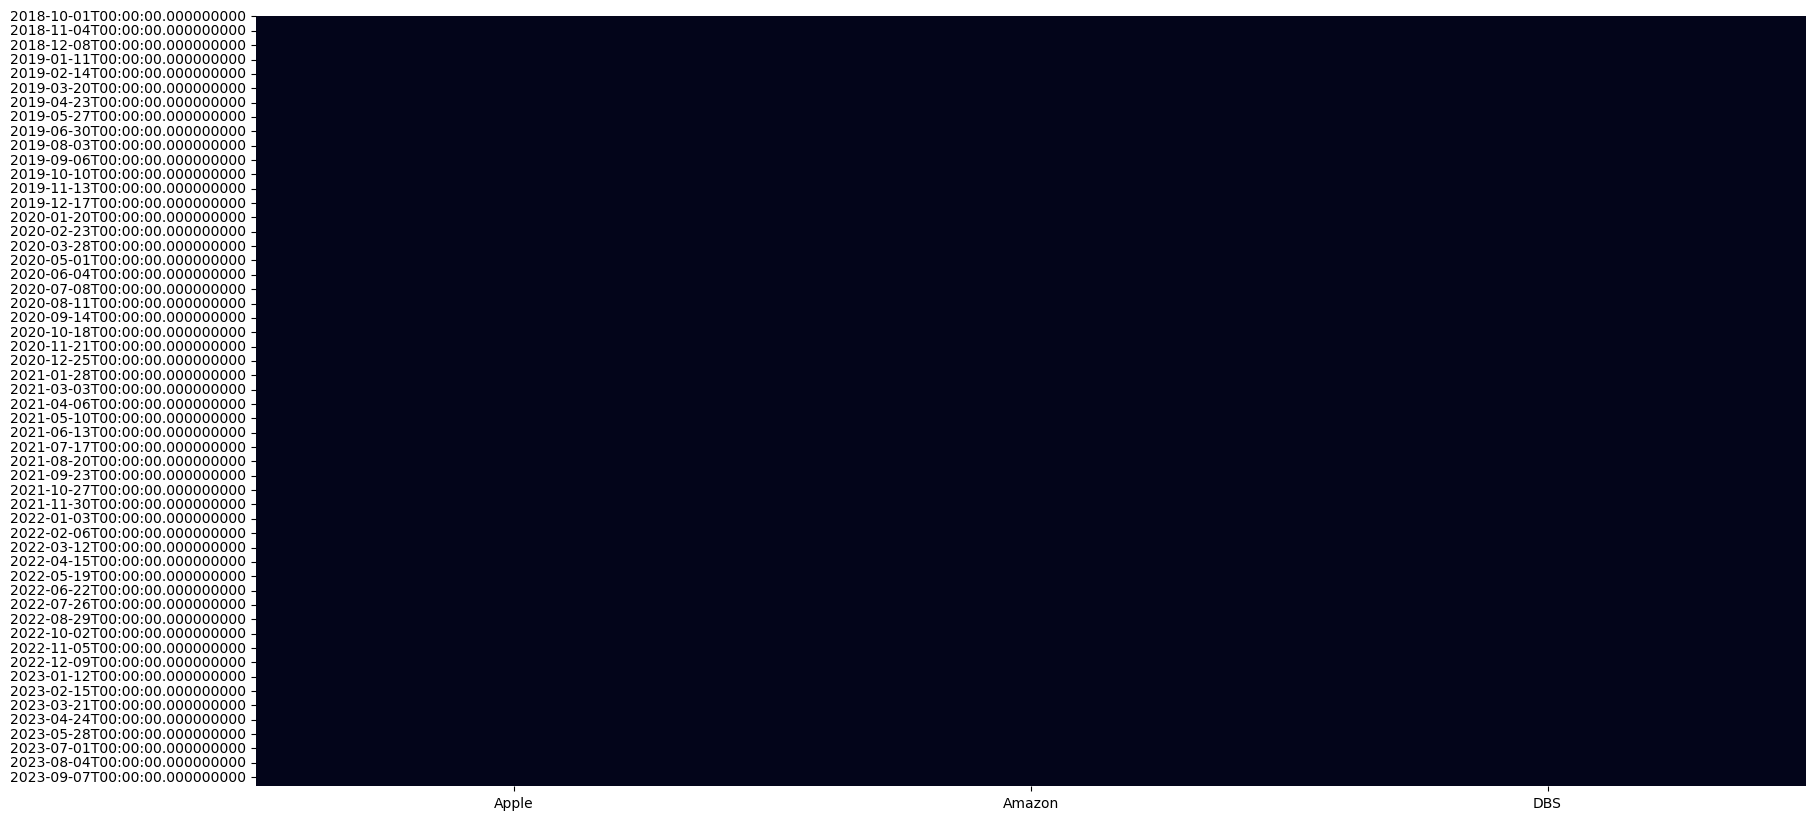

In [299]:
# Print out a heatmap to show how much missing data there is in the dataset
sns.heatmap(df.isnull(), cbar=False)

#### 1.3 Visualising the time series

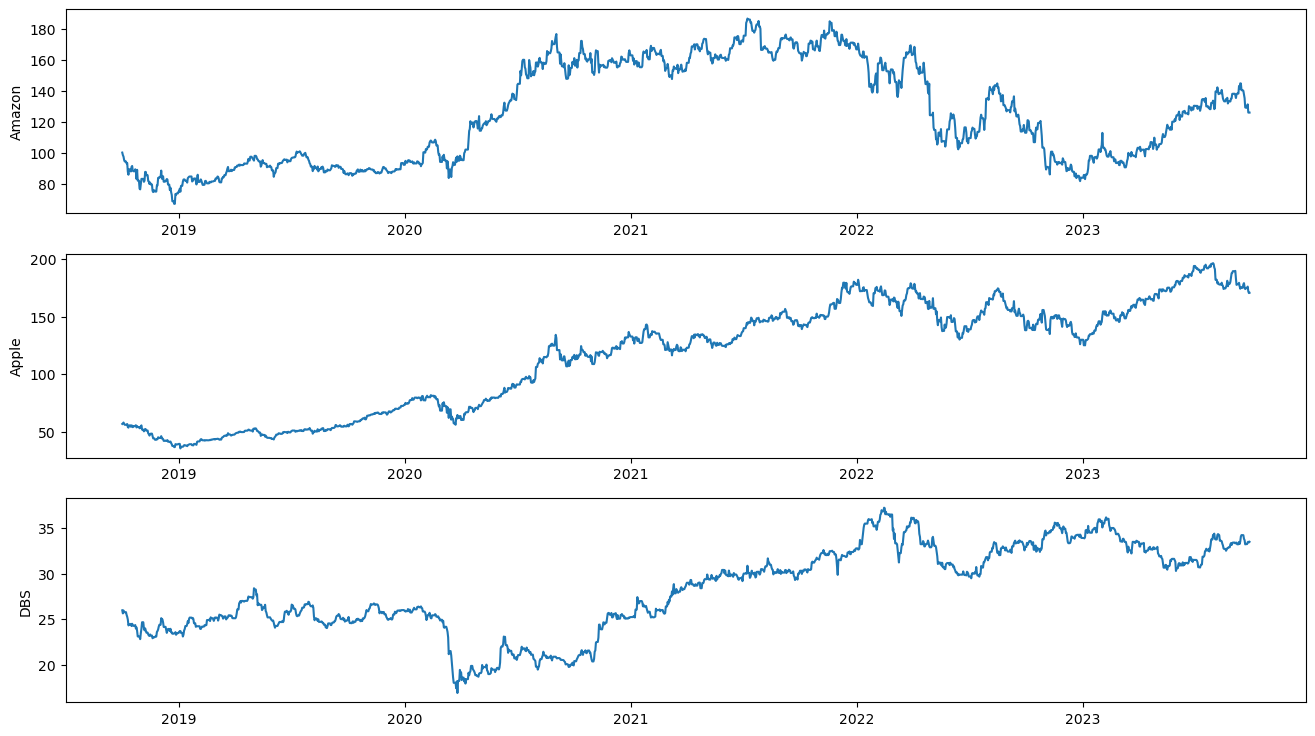

In [300]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(16,9))

sns.lineplot(df['Amazon'], ax=ax1)
sns.lineplot(df['Apple'], ax=ax2)
sns.lineplot(df['DBS'], ax=ax3)

plt.show()

#### 1.4 Time Series Decomposition

Seasonal Decomposition
Column: Apple


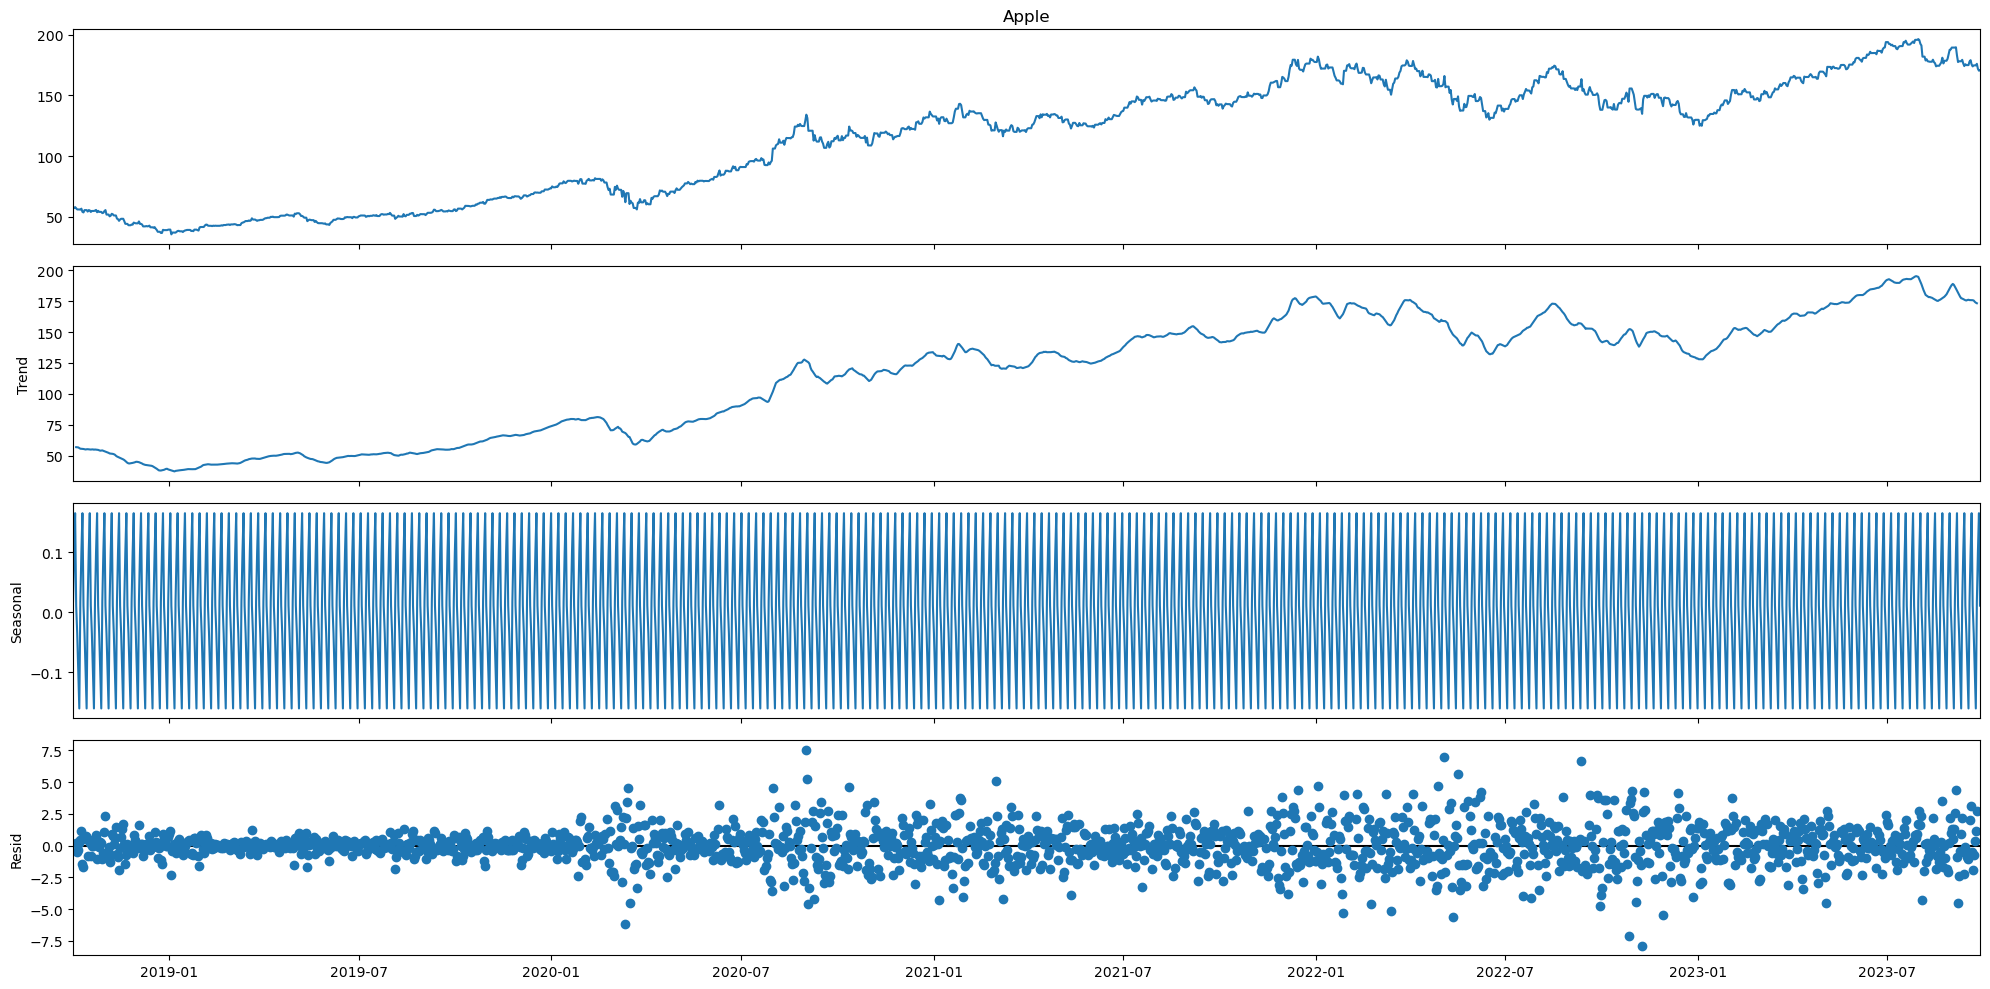

Seasonal Decomposition
Column: Amazon


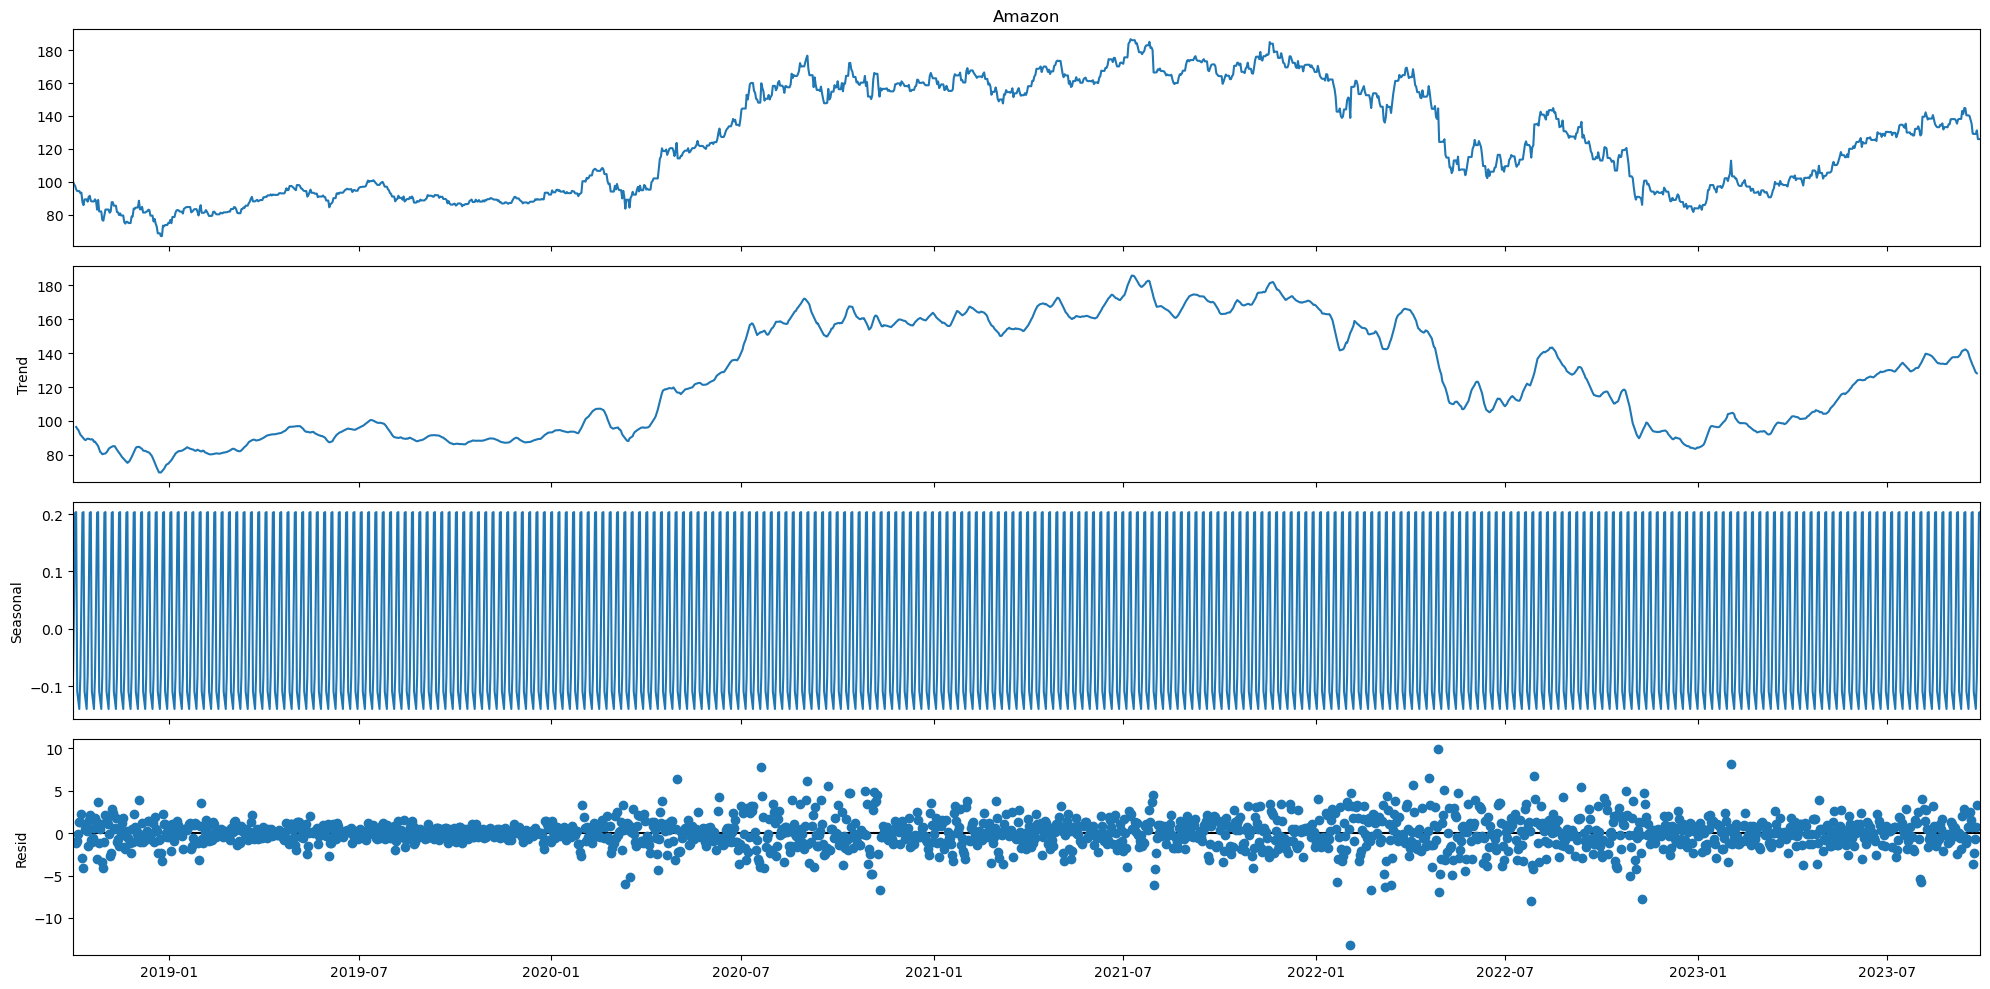

Seasonal Decomposition
Column: DBS


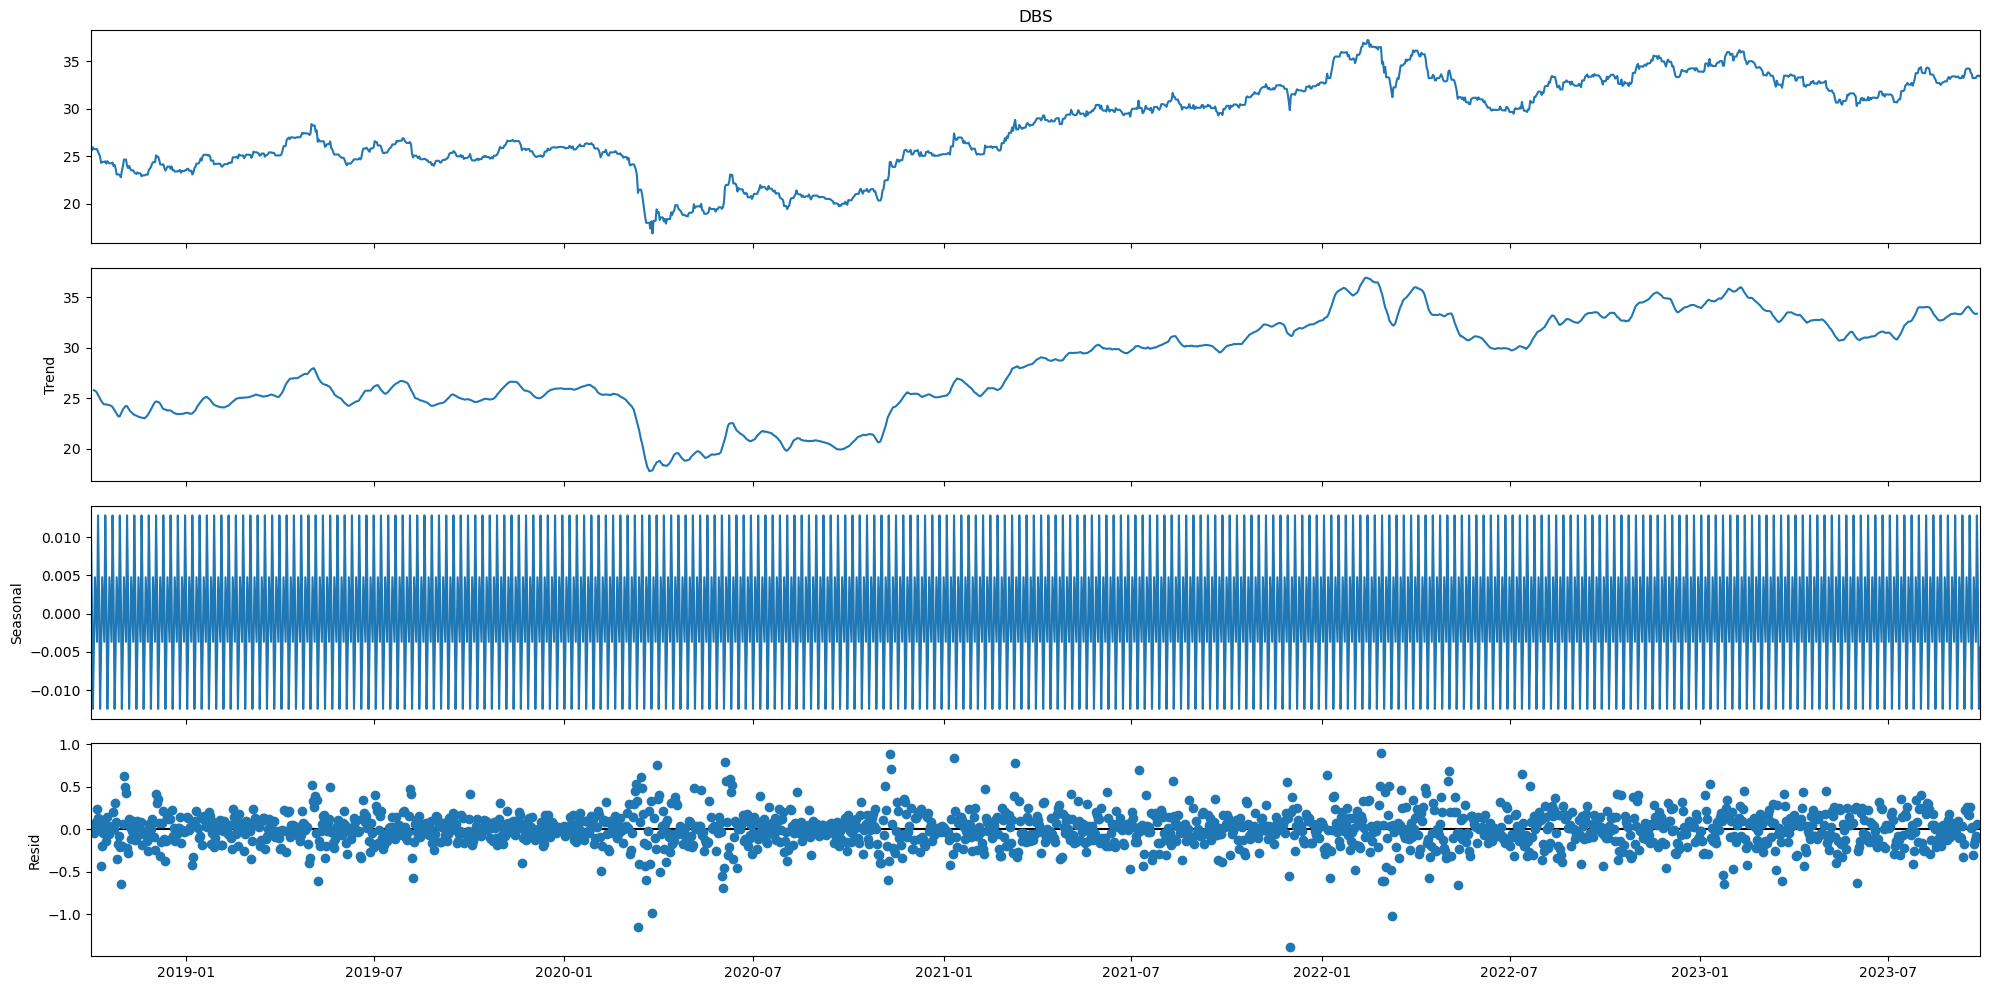

In [301]:
for i in df.columns:
    plt.rc("figure", figsize=(20, 10))
    print("Seasonal Decomposition\nColumn:", i)
    decomposition = seasonal_decompose(df[i])
    decomposition.plot()
    plt.show()

### 2. Checking if time series is stationary, white-noise, or non-stationary

In [302]:
df_amazon = df.copy()['Amazon']
df_apple = df.copy()['Apple']
df_dbs = df.copy()['DBS']

#### 2.1 Use ADF test to test for stationarity

##### 2.1.1 Amazon

In [303]:
# Test for Amazon
adf_result_amazon = adfuller(df_amazon)
print(f'ADF Statistic: {adf_result_amazon[0]}')
print(f'p-value: {adf_result_amazon[1]}')

ADF Statistic: -1.575605610379156
p-value: 0.4958349516623555


H0 : The series is non-stationary

H1 : The series is stationary

As p-value is larger than 0.05, we can't reject the null hypothesis of non-stationarity, in favour of non-stationarity.

We will have to convert the time series into a stationary series using differencing

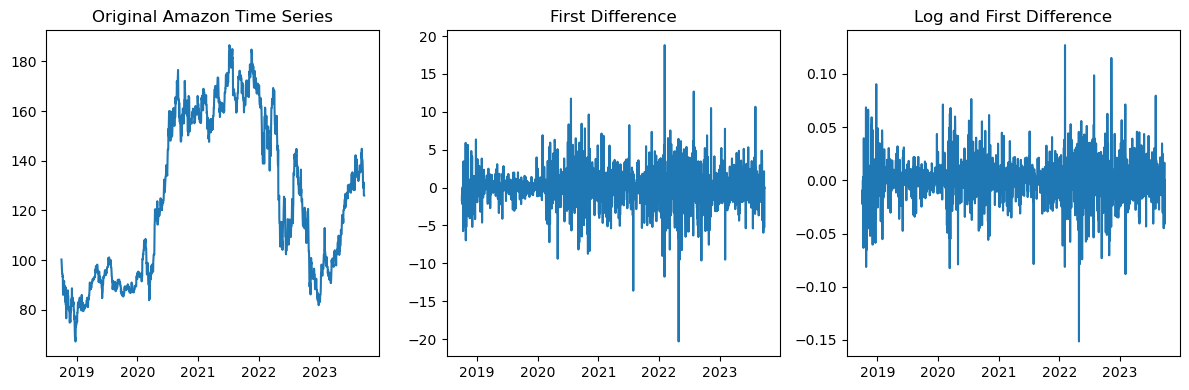

In [304]:
# Check if the series is stationary and transform the series if they are not
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(df_amazon)
plt.title('Original Amazon Time Series')

plt.subplot(1, 3, 2)
plt.plot(df_amazon.diff())
plt.title('First Difference')

plt.subplot(1, 3, 3)
plt.plot(np.log(df_amazon).diff())
plt.title('Log and First Difference')

plt.tight_layout()
plt.show()

From the graphs we can see that the logged first difference looks stationary and as such we will confirm that with the ADF test. To ensure homoscedasticity, we will log the first difference.

In [305]:
# Test for Amazon first difference
df_amazon = np.log(df_amazon).diff().dropna()
adf_result_amazon = adfuller(df_amazon)
print(f'ADF Statistic: {adf_result_amazon[0]}')
print(f'p-value: {adf_result_amazon[1]}')

ADF Statistic: -45.544593824154525
p-value: 0.0


We have successfully converted the Amazon time series into a stationary time series

##### 2.1.2 Apple

In [306]:
# Test for Apple
adf_result_apple = adfuller(df_apple)
print(f'ADF Statistic: {adf_result_apple[0]}')
print(f'p-value: {adf_result_apple[1]}')

ADF Statistic: -0.9838100771942361
p-value: 0.7591233096947595


H0 : The series is non-stationary

H1 : The series is stationary

As p-value is larger than 0.05, we can't reject the null hypothesis of non-stationarity, in favour of non-stationarity.

We will have to convert the time series into a stationary series using differencing

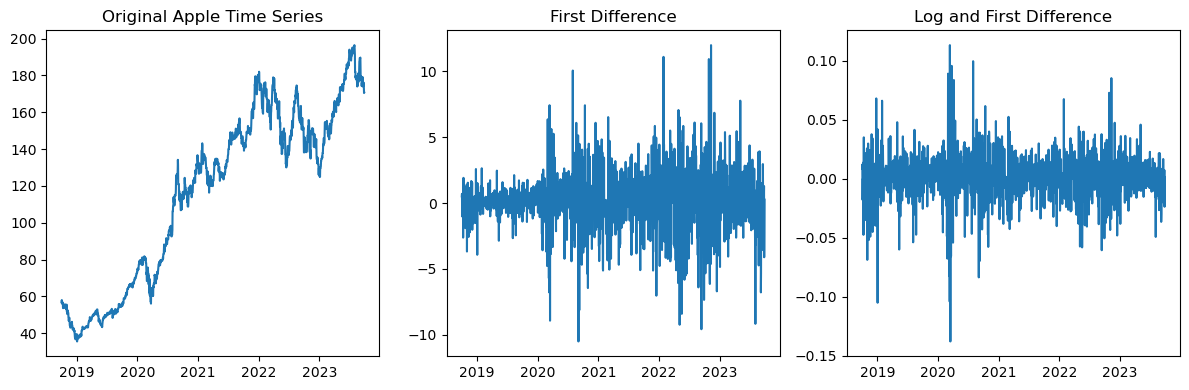

In [307]:
# Check if the series is stationary and transform the series if they are not
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(df_apple)
plt.title('Original Apple Time Series')

plt.subplot(1, 3, 2)
plt.plot(df_apple.diff())
plt.title('First Difference')

plt.subplot(1, 3, 3)
plt.plot(np.log(df_apple).diff())
plt.title('Log and First Difference')

plt.tight_layout()
plt.show()

From the graphs we can see that the logged first difference looks stationary and as such we will confirm that with the ADF test. To ensure homoscedasticity, we will log the first difference.

In [308]:
# Test for Apple first difference
df_apple = np.log(df_apple).diff().dropna()
adf_result_apple = adfuller(df_apple)
print(f'ADF Statistic: {adf_result_apple[0]}')
print(f'p-value: {adf_result_apple[1]}')

ADF Statistic: -8.600725224677648
p-value: 6.880735259649377e-14


We have successfully converted the Apple time series into a stationary time series

##### 2.1.3 DBS

In [309]:
# Test for DBS
adf_result_dbs = adfuller(df_dbs)
print(f'ADF Statistic: {adf_result_dbs[0]}')
print(f'p-value: {adf_result_dbs[1]}')

ADF Statistic: -1.2675427384561586
p-value: 0.6438876920102607


H0 : The series is non-stationary

H1 : The series is stationary

As p-value is larger than 0.05, we can't reject the null hypothesis of non-stationarity, in favour of non-stationarity.

We will have to convert the time series into a stationary series using differencing

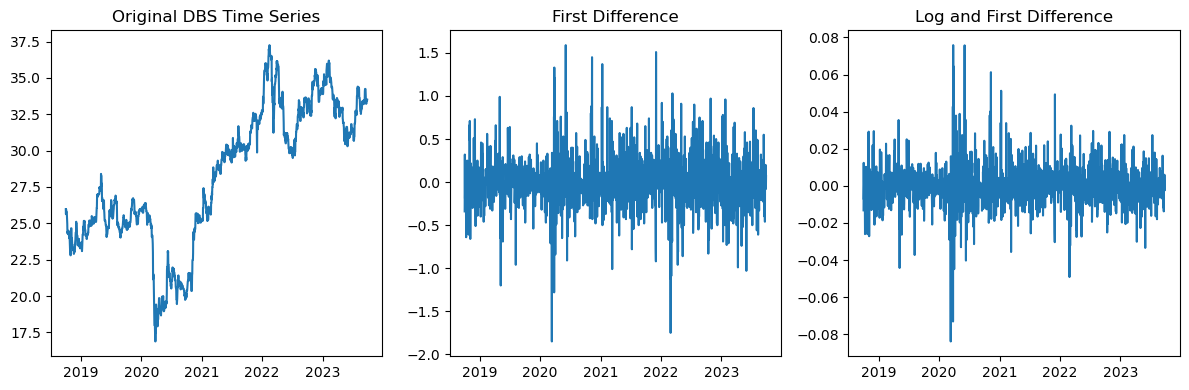

In [310]:
# Check if the series is stationary and transform the series if they are not
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(df_dbs)
plt.title('Original DBS Time Series')

plt.subplot(1, 3, 2)
plt.plot(df_dbs.diff())
plt.title('First Difference')

plt.subplot(1, 3, 3)
plt.plot(np.log(df_dbs).diff())
plt.title('Log and First Difference')

plt.tight_layout()
plt.show()

From the graphs we can see that the logged first difference looks stationary and as such we will confirm that with the ADF test. To ensure homoscedasticity, we will log the first difference.

In [311]:
# Test for DBS first difference
df_dbs = np.log(df_dbs).diff().dropna()
adf_result_dbs = adfuller(df_dbs)
print(f'ADF Statistic: {adf_result_dbs[0]}')
print(f'p-value: {adf_result_dbs[1]}')

ADF Statistic: -13.15584438676391
p-value: 1.337841395234658e-24


We have successfully converted the DBS time series into a stationary time series

#### 2.2 Use Ljung-Box test to see if the time series is white noise

#### 2.2.1 Amazon

In [312]:
# Apply Ljung-Box test for serial correlations up to lag 20
lb_result_single = acorr_ljungbox(df_amazon, lags=[20], return_df=True)

# Display the single Ljung-Box test result
lb_result_single.iloc[0]

lb_stat      42.410703
lb_pvalue     0.002444
Name: 20, dtype: float64

* H0 : The series has no autocorrelation (i.e. autocorrelation = 0)
* H1 : The series has autocorrelation    (i.e. autocorrelation is not = 0)

Since p-value (0.015739) is < 0.05, it indicates that there is enough statistical evidence to reject the null hypothesis of no autocorrelation at any of the lags up to 20. This is not consistent with the expected behavior of a white noise time series

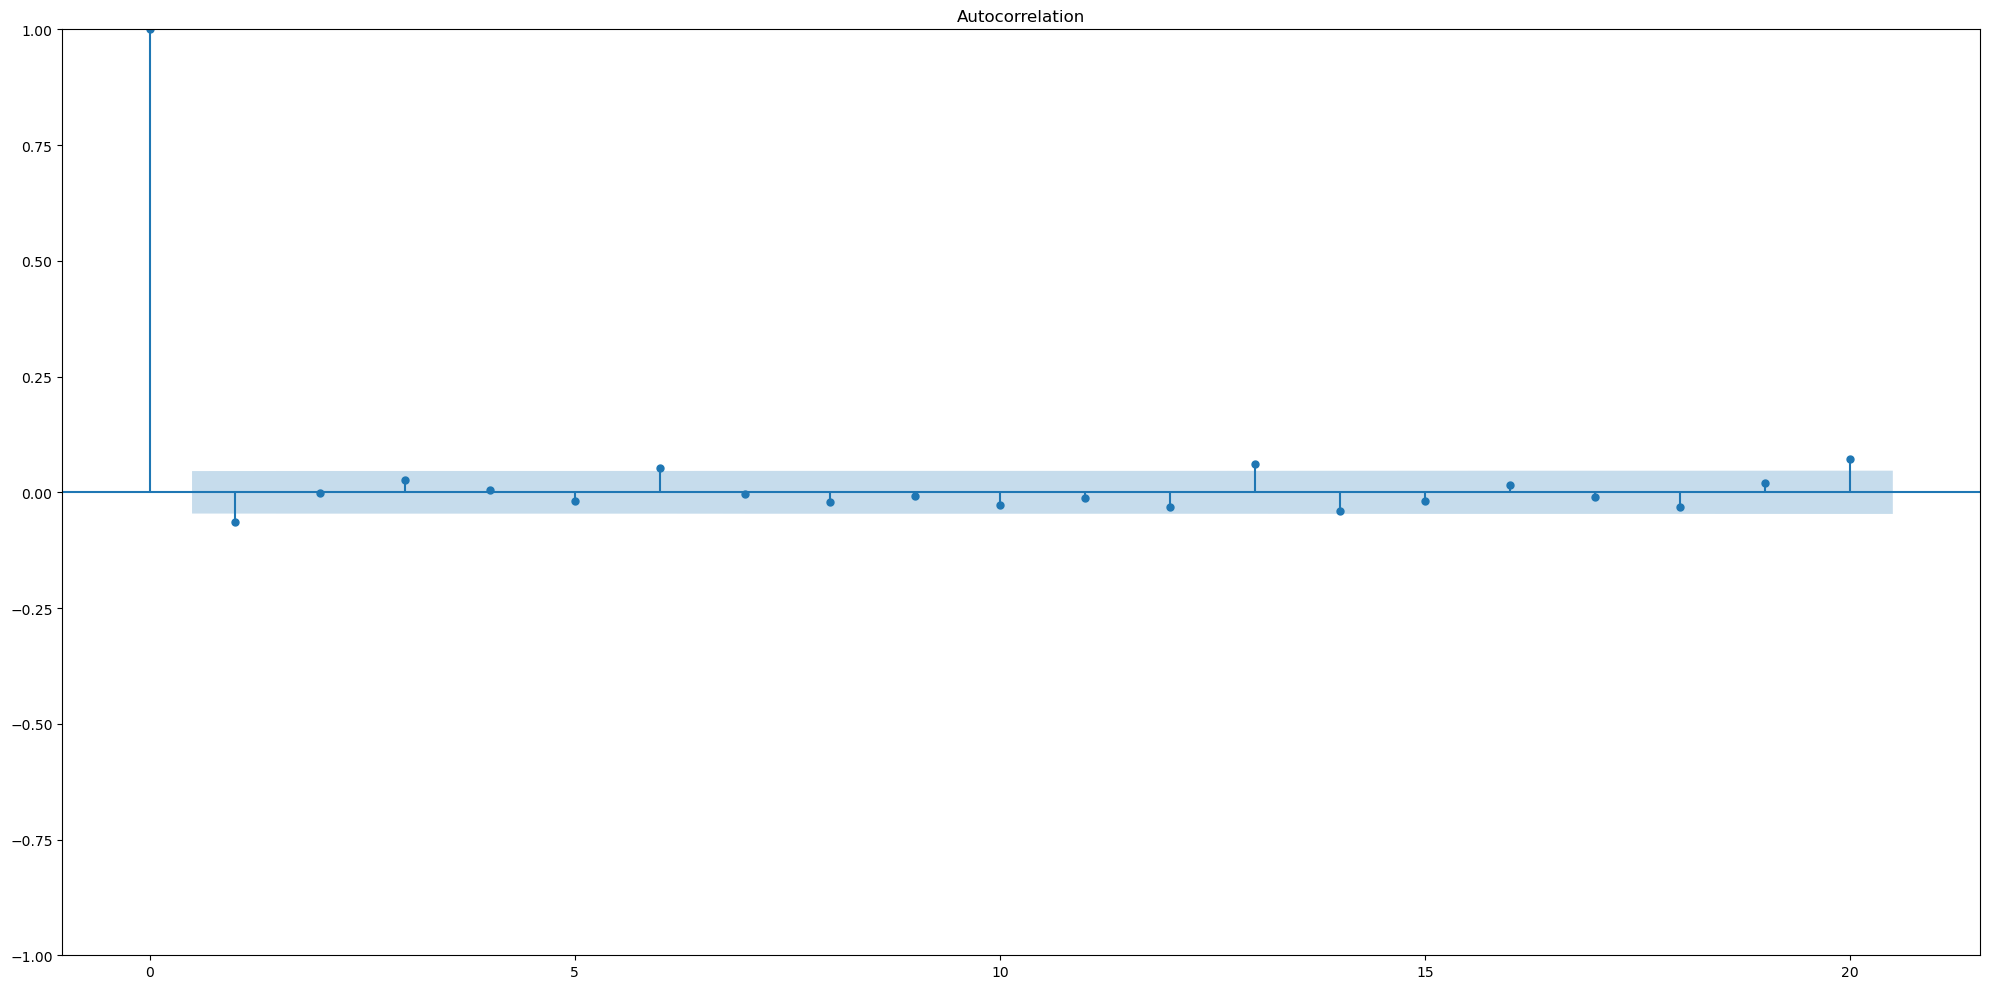

In [313]:
plot_acf(df_amazon, ax=plt.gca(), lags=20)
plt.tight_layout()

Since the ACF plot (Autocorrelation) has significant spikes, this implies presence of autocorrelations between lags.

We can therefore conclude that the Amazon time series is not white noise.

#### 2.2.2 Apple

In [314]:
# Apply Ljung-Box test for serial correlations up to lag 20
lb_result_single = acorr_ljungbox(df_apple, lags=[20], return_df=True)

# Display the single Ljung-Box test result
lb_result_single.iloc[0]

lb_stat      1.101298e+02
lb_pvalue    1.859867e-14
Name: 20, dtype: float64

* H0 : The series has no autocorrelation (i.e. autocorrelation = 0)
* H1 : The series has autocorrelation    (i.e. autocorrelation is not = 0)

Since p-value (0.000016) is < 0.05, it indicates that there is enough statistical evidence to reject the null hypothesis of no autocorrelation at any of the lags up to 20. This is not consistent with the expected behavior of a white noise time series

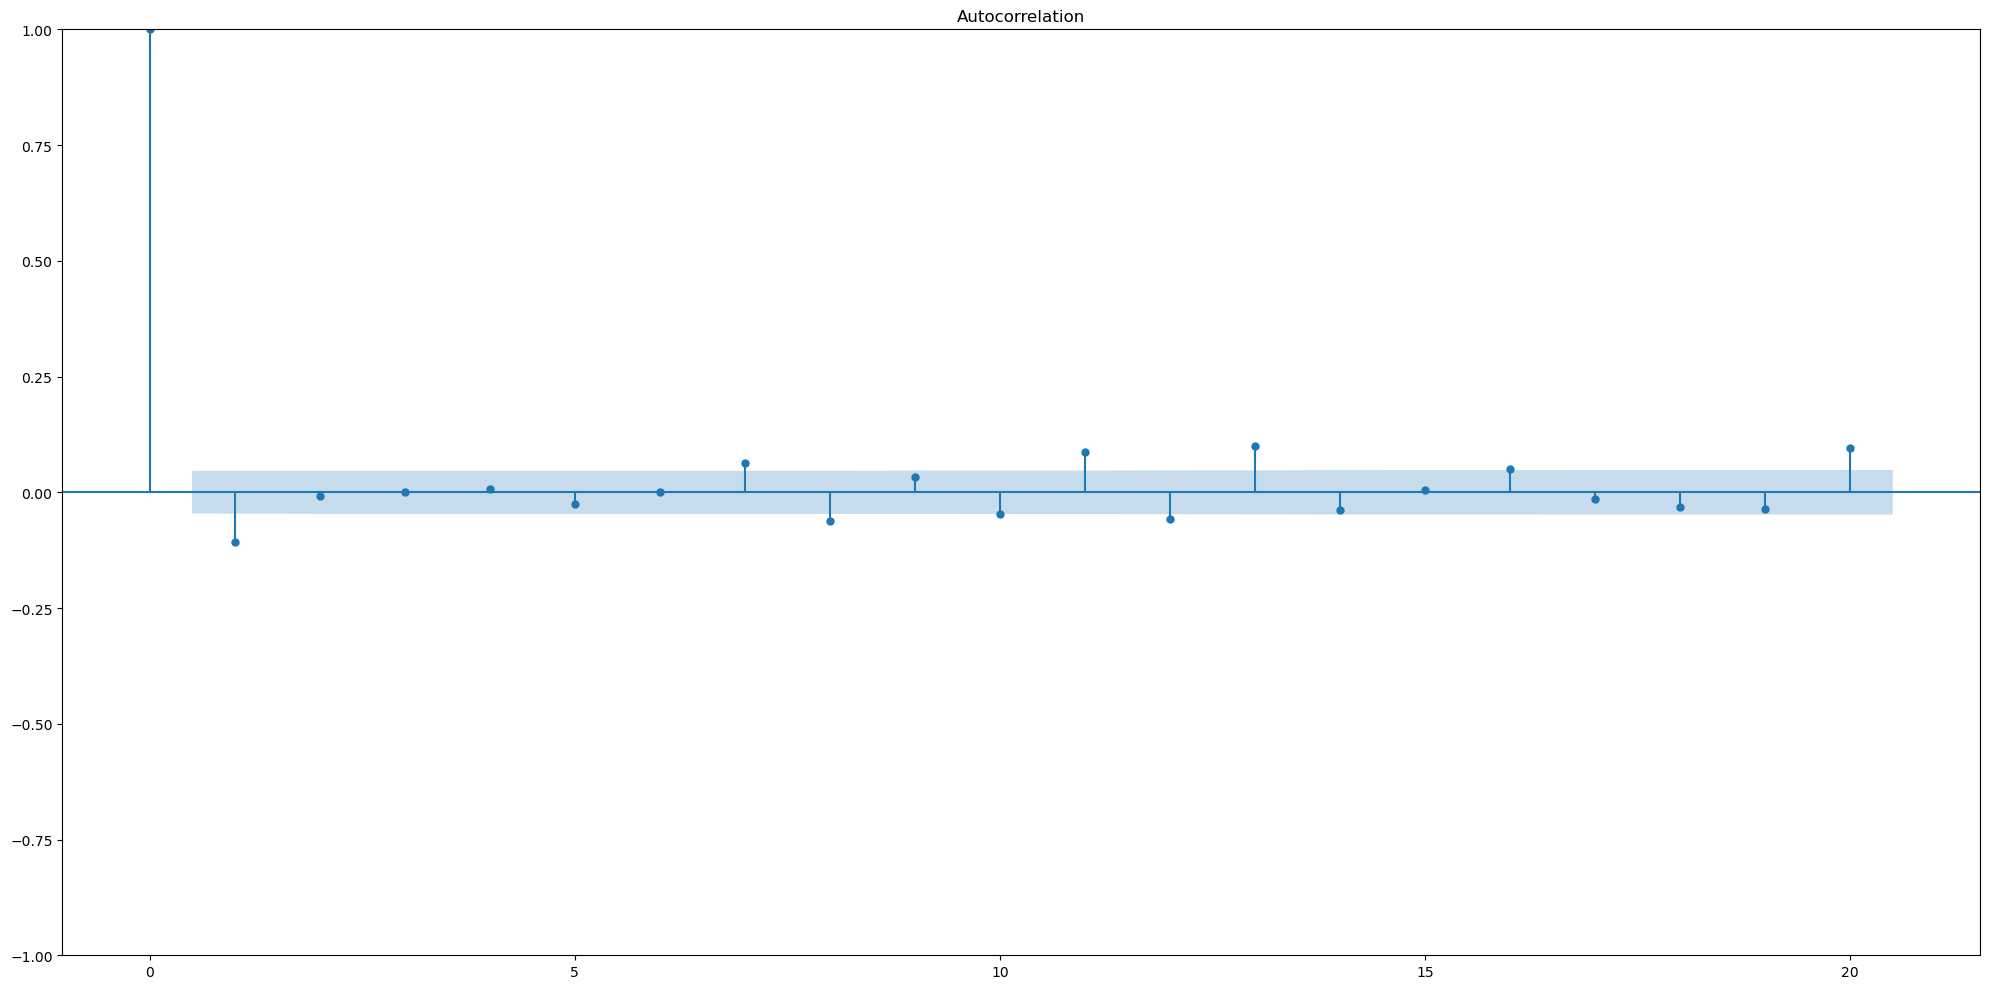

In [315]:
plot_acf(df_apple, ax=plt.gca(), lags=20)
plt.tight_layout()

Since the ACF plot (Autocorrelation) has significant spikes, this implies presence of autocorrelations between lags.

We can therefore conclude that the Apple time series is not white noise.

#### 2.2.3 DBS

In [316]:
# Apply Ljung-Box test for serial correlations up to lag 20
lb_result_single = acorr_ljungbox(df_dbs, lags=[20], return_df=True)

# Display the single Ljung-Box test result
lb_result_single.iloc[0]

lb_stat      61.955691
lb_pvalue     0.000004
Name: 20, dtype: float64

* H0 : The series has no autocorrelation (i.e. autocorrelation = 0)
* H1 : The series has autocorrelation    (i.e. autocorrelation is not = 0)

Since p-value (0.000004) is < 0.05, it indicates that there is enough statistical evidence to reject the null hypothesis of no autocorrelation at any of the lags up to 20. This is not consistent with the expected behavior of a white noise time series

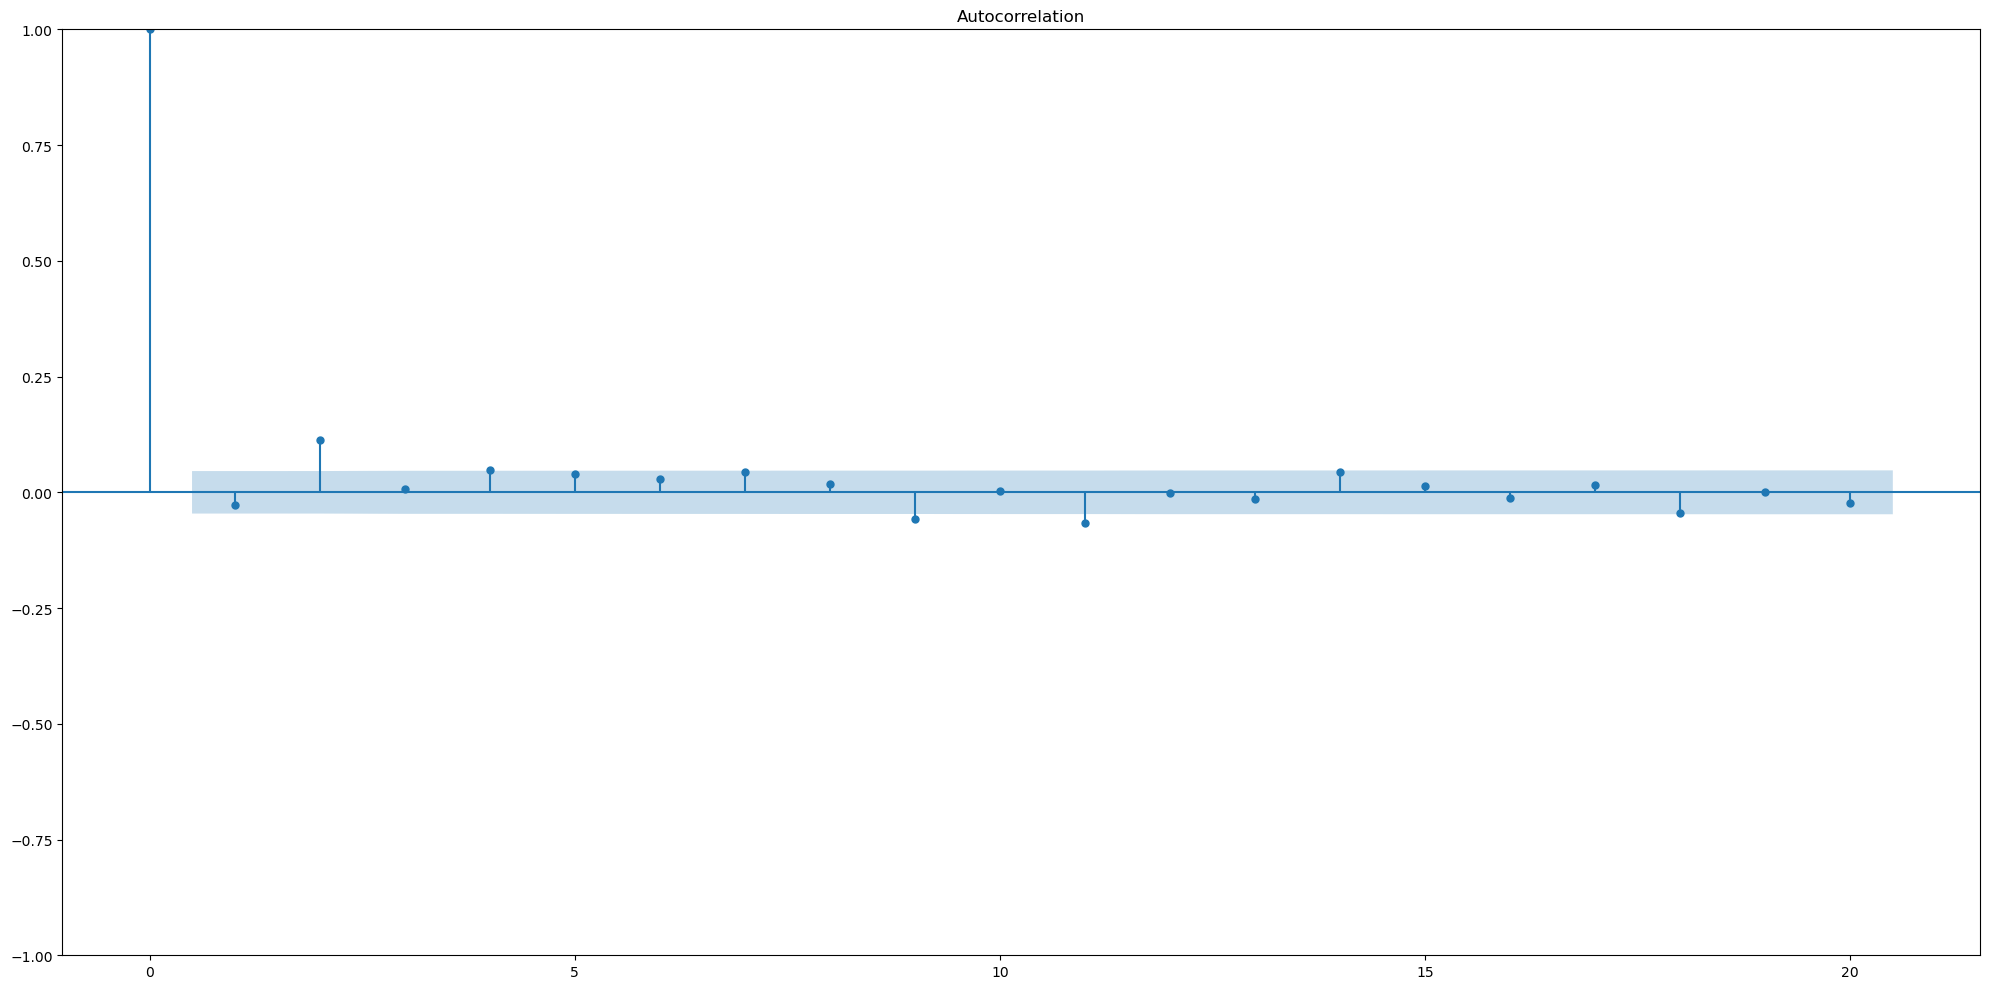

In [317]:
plot_acf(df_dbs, ax=plt.gca(), lags=20)
plt.tight_layout()

Since the ACF plot (Autocorrelation) has significant spikes, this implies presence of autocorrelations between lags.

We can therefore conclude that the DBS time series is not white noise.

### 3. Tuning the hyperparameters of ARIMA models

#### Getting A Dataset To Be Used For Exog

In [318]:
exog_dataset = pd.concat([df_amazon, df_apple, df_dbs], axis=1)
exog_dataset

,Amazon,Apple,DBS
2018-10-02,-0.016627,0.008849,-0.013178
2018-10-03,-0.009455,0.012095,0.012408
2018-10-04,-0.022444,-0.017737,-0.007349
2018-10-05,-0.010408,-0.016362,0.000388
2018-10-06,0.000000,0.000000,0.000000
...,...,...,...
2023-09-24,0.000000,0.000000,0.000000
2023-09-25,0.016514,0.007353,0.005997
2023-09-26,-0.041133,-0.023677,0.001792
2023-09-27,0.000000,-0.008937,-0.002390


Setting up manual ARIMA function

In [325]:
def manual_arima(p_values, d_values, q_values, P_values, D_values, Q_values, s_values, training_data, exog):
    # Initialize best values
    best_aic = float("inf")
    best_order = None
    best_seasonal_order = None

    permutation = list(product(p_values, d_values, q_values, P_values, D_values, Q_values))

    count = 1
    # Perform grid search
    for p, d, q, P, D, Q in product(p_values, d_values, q_values, P_values, D_values, Q_values):
        order = (p, d, q)
        seasonal_order = (P, D, Q, s_values[0])  # Assuming the same seasonal period for all combinations

        # Fit SARIMA model
        model = SARIMAX(training_data, order=order, seasonal_order=seasonal_order, exog=exog)
        results = model.fit(disp=False)
        aic = results.aic

        # Update best values if a better model is found
        if aic < best_aic:
            best_aic = aic
            best_order = order
            best_seasonal_order = seasonal_order
        
        print(f"Completed {count}/{len(permutation)} {order} with seasonal order {seasonal_order}")

        count += 1

    return {"best_aic": best_aic, "best_order": best_order, "best_seasonal_order": best_seasonal_order}

#### 3.1 Amazon

In [320]:
df_amazon

2018-10-02   -0.016627
2018-10-03   -0.009455
2018-10-04   -0.022444
2018-10-05   -0.010408
2018-10-06    0.000000
                ...   
2023-09-24    0.000000
2023-09-25    0.016514
2023-09-26   -0.041133
2023-09-27    0.000000
2023-09-28    0.000000
Freq: D, Name: Amazon, Length: 1823, dtype: float64

In [321]:
# Splitting the dataset for prediction
df_amazon_train_data = df_amazon.iloc[:len(df_amazon)-60]
df_amazon_test_data = df_amazon.iloc[len(df_amazon)-60:]

print(f"Percentage of training data: {(len(df_amazon_train_data)/len(df_amazon))*100}%")
print(f"Percentage of test data: {(len(df_amazon_test_data)/len(df_amazon))*100}%")

Percentage of training data: 96.70872188699946%
Percentage of test data: 3.2912781130005486%


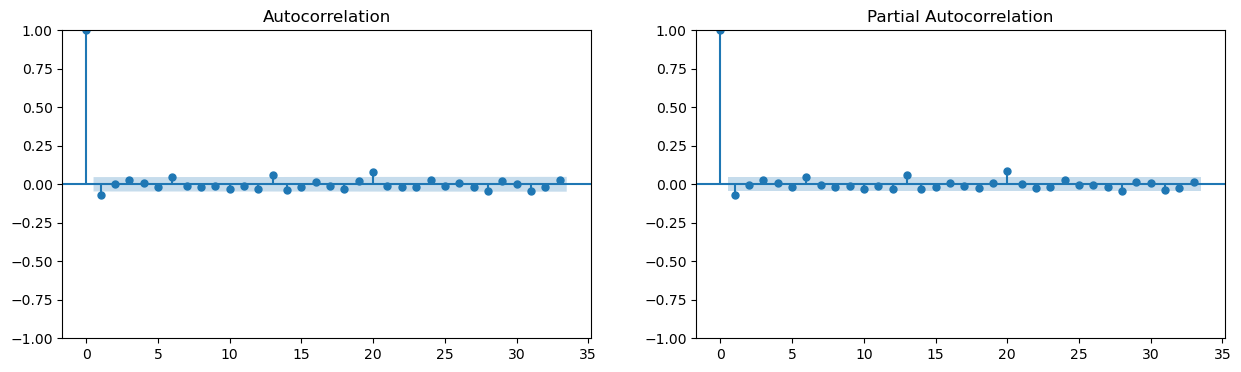

In [322]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(df_amazon_train_data, ax=axes[0])
plot_pacf(df_amazon_train_data, ax=axes[1])
plt.show()

##### 3.1.1 Getting MSE and best hyperparameters with Apple as exog

In [328]:
# Grid search ranges
p_values = range(0,3)
d_values = range(2)
q_values = range(2)
P_values = range(1,3)
D_values = [1]
Q_values = range(2)
s_values = [12]  # Assuming monthly data

amazon_with_apple = manual_arima(p_values, d_values, q_values, P_values, D_values, Q_values, s_values, df_amazon_train_data, exog_dataset[['Apple']][:len(df_amazon)-60])

print(f"Best AIC: {amazon_with_apple['best_aic']}")
print(f"Best (p, d, q) order: {amazon_with_apple['best_order']}")
print(f"Best (P, D, Q, s) seasonal order: {amazon_with_apple['best_seasonal_order']}")

Completed 1/48 (0, 0, 0) with seasonal order (1, 1, 0, 12)
Completed 2/48 (0, 0, 0) with seasonal order (1, 1, 1, 12)
Completed 3/48 (0, 0, 0) with seasonal order (2, 1, 0, 12)
Completed 4/48 (0, 0, 0) with seasonal order (2, 1, 1, 12)
Completed 5/48 (0, 0, 1) with seasonal order (1, 1, 0, 12)
Completed 6/48 (0, 0, 1) with seasonal order (1, 1, 1, 12)
Completed 7/48 (0, 0, 1) with seasonal order (2, 1, 0, 12)
Completed 8/48 (0, 0, 1) with seasonal order (2, 1, 1, 12)
Completed 9/48 (0, 1, 0) with seasonal order (1, 1, 0, 12)
Completed 10/48 (0, 1, 0) with seasonal order (1, 1, 1, 12)
Completed 11/48 (0, 1, 0) with seasonal order (2, 1, 0, 12)
Completed 12/48 (0, 1, 0) with seasonal order (2, 1, 1, 12)
Completed 13/48 (0, 1, 1) with seasonal order (1, 1, 0, 12)
Completed 14/48 (0, 1, 1) with seasonal order (1, 1, 1, 12)
Completed 15/48 (0, 1, 1) with seasonal order (2, 1, 0, 12)
Completed 16/48 (0, 1, 1) with seasonal order (2, 1, 1, 12)
Completed 17/48 (1, 0, 0) with seasonal order (1,

In [329]:
amazon_with_apple_model = SARIMAX(df_amazon_train_data, order=amazon_with_apple['best_order'], seasonal_order=amazon_with_apple['best_seasonal_order'], exog=exog_dataset[['Apple']][:len(df_amazon)-60])
amazon_with_apple_result = amazon_with_apple_model.fit()

print(amazon_with_apple_result.summary())

                                 SARIMAX Results                                  
Dep. Variable:                     Amazon   No. Observations:                 1763
Model:             SARIMAX(1, 1, [1], 12)   Log Likelihood                4884.682
Date:                    Fri, 09 Feb 2024   AIC                          -9761.365
Time:                            15:50:35   BIC                          -9739.493
Sample:                        10-02-2018   HQIC                         -9753.280
                             - 07-30-2023                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Apple          0.7182      0.011     67.126      0.000       0.697       0.739
ar.S.L12      -0.0205      0.028     -0.740      0.460      -0.075       0.034
ma.S.L12      -0.998

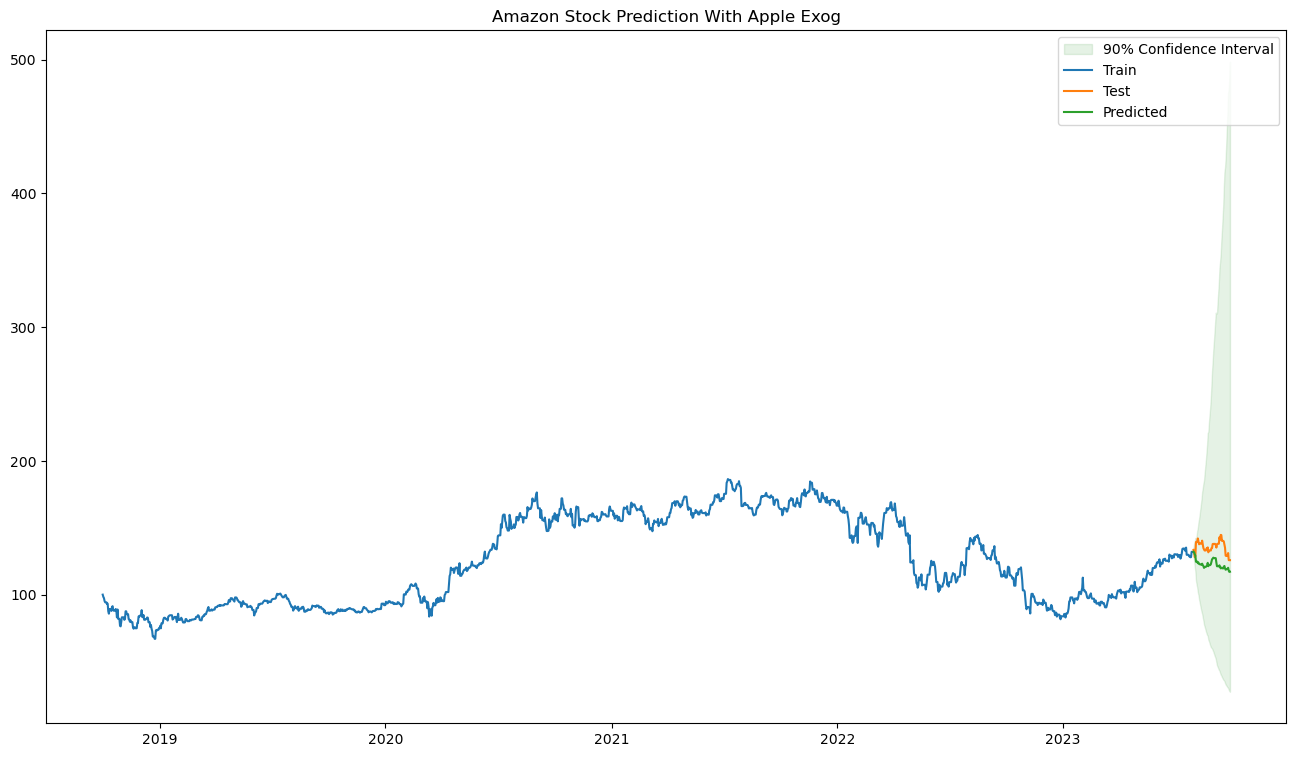

In [330]:
# Splitting the dataset for prediction
df_amazon_train_data_unmodified = df['Amazon'].iloc[:len(df['Amazon'])-60]
df_amazon_test_data_unmodified = df['Amazon'].iloc[len(df['Amazon'])-60:]

# Make predictions
predictions = amazon_with_apple_result.predict(start=len(df_amazon_train_data_unmodified)-1, 
                                            end=len(df_amazon_train_data_unmodified)+58, exog=exog_dataset[['Apple']][len(df_amazon)-60:])

forecast_ci = amazon_with_apple_result.get_prediction(start=len(df_amazon_train_data_unmodified)-1, 
                                            end=len(df_amazon_train_data_unmodified)+58, exog=exog_dataset[['Apple']][len(df_amazon)-60:]).summary_frame(alpha=0.1)

# Compare predictions with actual data
plt.figure(figsize=(16,9))
last_observed_value = df_amazon_train_data_unmodified.iloc[-1]
forecast_original = np.cumsum(np.insert(predictions, 0, np.log(last_observed_value)))[1:]
forecast_ci['mean_ci_lower'] = np.cumsum(np.insert(forecast_ci['mean_ci_lower'], 0, np.log(last_observed_value)))[1:]
forecast_ci['mean_ci_upper'] = np.cumsum(np.insert(forecast_ci['mean_ci_upper'], 0, np.log(last_observed_value)))[1:]

plt.fill_between(forecast_ci.index, np.exp(forecast_ci['mean_ci_lower']), np.exp(forecast_ci['mean_ci_upper']), color='green', alpha=0.1, label='90% Confidence Interval')
plt.plot(df_amazon_train_data_unmodified.index, df_amazon_train_data_unmodified, label='Train')
plt.plot(df_amazon_test_data_unmodified.index, df_amazon_test_data_unmodified, label='Test')
plt.plot(predictions.index, np.exp(forecast_original), label='Predicted')
plt.title('Amazon Stock Prediction With Apple Exog')
plt.legend()
plt.show()

amazon_with_apple['mse'] = mean_squared_error(df_amazon_test_data_unmodified, np.exp(forecast_original))

##### 3.1.2 Getting MSE and best hyperparameters with DBS as exog

In [332]:
# Grid search ranges
p_values = range(0,3)
d_values = range(2)
q_values = range(2)
P_values = range(1,3)
D_values = [1]
Q_values = range(2)
s_values = [12]  # Assuming monthly data

amazon_with_dbs = manual_arima(p_values, d_values, q_values, P_values, D_values, Q_values, s_values, df_amazon_train_data, exog_dataset[['DBS']][:len(df_amazon)-60])

print(f"Best AIC: {amazon_with_dbs['best_aic']}")
print(f"Best (p, d, q) order: {amazon_with_dbs['best_order']}")
print(f"Best (P, D, Q, s) seasonal order: {amazon_with_dbs['best_seasonal_order']}")

Completed 1/48 (0, 0, 0) with seasonal order (1, 1, 0, 12)
Completed 2/48 (0, 0, 0) with seasonal order (1, 1, 1, 12)
Completed 3/48 (0, 0, 0) with seasonal order (2, 1, 0, 12)
Completed 4/48 (0, 0, 0) with seasonal order (2, 1, 1, 12)
Completed 5/48 (0, 0, 1) with seasonal order (1, 1, 0, 12)
Completed 6/48 (0, 0, 1) with seasonal order (1, 1, 1, 12)
Completed 7/48 (0, 0, 1) with seasonal order (2, 1, 0, 12)
Completed 8/48 (0, 0, 1) with seasonal order (2, 1, 1, 12)
Completed 9/48 (0, 1, 0) with seasonal order (1, 1, 0, 12)
Completed 10/48 (0, 1, 0) with seasonal order (1, 1, 1, 12)
Completed 11/48 (0, 1, 0) with seasonal order (2, 1, 0, 12)
Completed 12/48 (0, 1, 0) with seasonal order (2, 1, 1, 12)
Completed 13/48 (0, 1, 1) with seasonal order (1, 1, 0, 12)
Completed 14/48 (0, 1, 1) with seasonal order (1, 1, 1, 12)
Completed 15/48 (0, 1, 1) with seasonal order (2, 1, 0, 12)
Completed 16/48 (0, 1, 1) with seasonal order (2, 1, 1, 12)
Completed 17/48 (1, 0, 0) with seasonal order (1,

In [333]:
amazon_with_dbs_model = SARIMAX(df_amazon_train_data, order=amazon_with_dbs['best_order'], seasonal_order=amazon_with_dbs['best_seasonal_order'], exog=exog_dataset[['DBS']][:len(df_amazon)-60])
amazon_with_dbs_result = amazon_with_dbs_model.fit()

print(amazon_with_dbs_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             Amazon   No. Observations:                 1763
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 12)   Log Likelihood                4405.614
Date:                            Fri, 09 Feb 2024   AIC                          -8801.227
Time:                                    15:57:47   BIC                          -8773.888
Sample:                                10-02-2018   HQIC                         -8791.121
                                     - 07-30-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
DBS            0.0914      0.029      3.166      0.002       0.035       0.148
ma.L1         -0.0701      0.017   

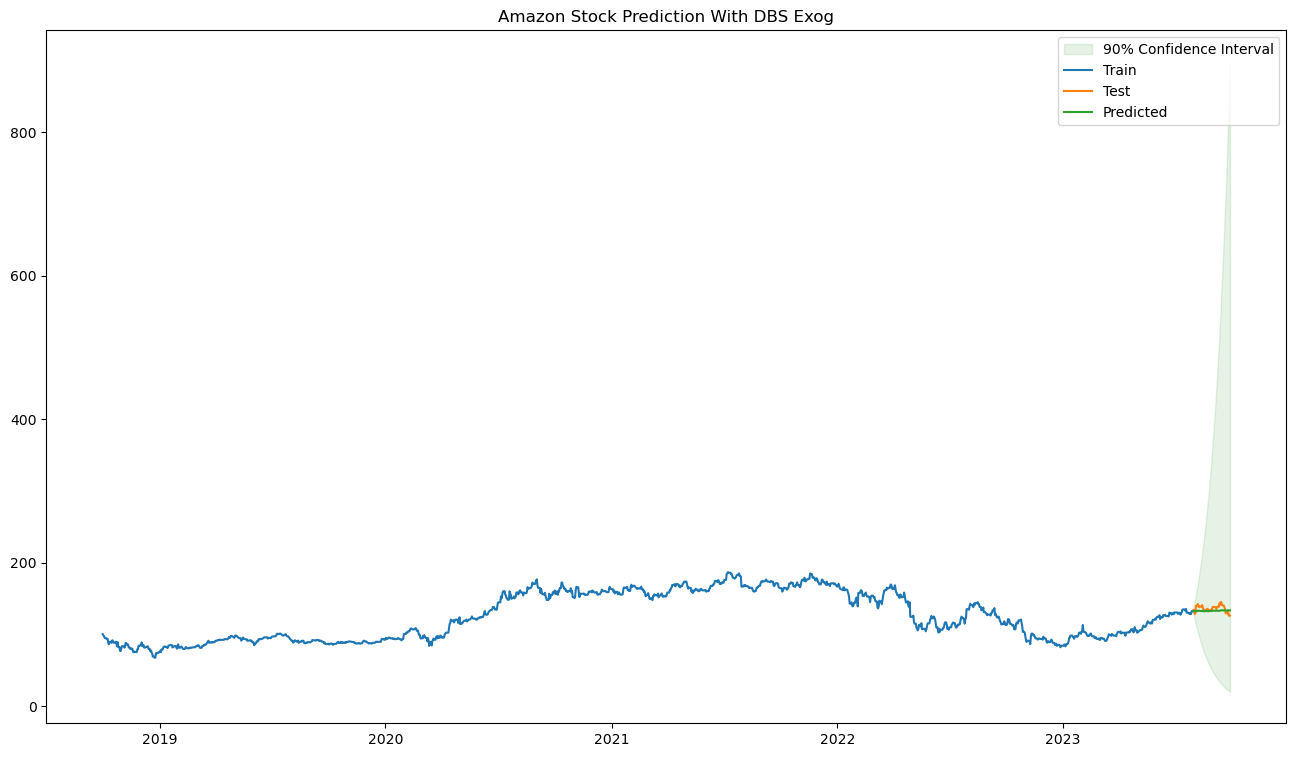

In [334]:
# Splitting the dataset for prediction
df_amazon_train_data_unmodified = df['Amazon'].iloc[:len(df['Amazon'])-60]
df_amazon_test_data_unmodified = df['Amazon'].iloc[len(df['Amazon'])-60:]

# Make predictions
predictions = amazon_with_dbs_result.predict(start=len(df_amazon_train_data_unmodified)-1, 
                                            end=len(df_amazon_train_data_unmodified)+58, exog=exog_dataset[['DBS']][len(df_amazon)-60:])

forecast_ci = amazon_with_dbs_result.get_prediction(start=len(df_amazon_train_data_unmodified)-1, 
                                            end=len(df_amazon_train_data_unmodified)+58, exog=exog_dataset[['DBS']][len(df_amazon)-60:]).summary_frame(alpha=0.1)

# Compare predictions with actual data
plt.figure(figsize=(16,9))
last_observed_value = df_amazon_train_data_unmodified.iloc[-1]
forecast_original = np.cumsum(np.insert(predictions, 0, np.log(last_observed_value)))[1:]
forecast_ci['mean_ci_lower'] = np.cumsum(np.insert(forecast_ci['mean_ci_lower'], 0, np.log(last_observed_value)))[1:]
forecast_ci['mean_ci_upper'] = np.cumsum(np.insert(forecast_ci['mean_ci_upper'], 0, np.log(last_observed_value)))[1:]

plt.fill_between(forecast_ci.index, np.exp(forecast_ci['mean_ci_lower']), np.exp(forecast_ci['mean_ci_upper']), color='green', alpha=0.1, label='90% Confidence Interval')
plt.plot(df_amazon_train_data_unmodified.index, df_amazon_train_data_unmodified, label='Train')
plt.plot(df_amazon_test_data_unmodified.index, df_amazon_test_data_unmodified, label='Test')
plt.plot(predictions.index, np.exp(forecast_original), label='Predicted')
plt.title('Amazon Stock Prediction With DBS Exog')
plt.legend()
plt.show()

amazon_with_dbs['mse'] = mean_squared_error(df_amazon_test_data_unmodified, np.exp(forecast_original))

##### 3.1.3 Getting MSE and best hyperparameters with Apple and DBS as exog

In [335]:
# Grid search ranges
p_values = range(0,3)
d_values = range(2)
q_values = range(2)
P_values = range(1,3)
D_values = [1]
Q_values = range(2)
s_values = [12]  # Assuming monthly data

amazon_with_apple_and_dbs = manual_arima(p_values, d_values, q_values, P_values, D_values, Q_values, s_values, df_amazon_train_data, exog_dataset[['Apple', 'DBS']][:len(df_amazon)-60])

print(f"Best AIC: {amazon_with_apple_and_dbs['best_aic']}")
print(f"Best (p, d, q) order: {amazon_with_apple_and_dbs['best_order']}")
print(f"Best (P, D, Q, s) seasonal order: {amazon_with_apple_and_dbs['best_seasonal_order']}")

Completed 1/48 (0, 0, 0) with seasonal order (1, 1, 0, 12)
Completed 2/48 (0, 0, 0) with seasonal order (1, 1, 1, 12)
Completed 3/48 (0, 0, 0) with seasonal order (2, 1, 0, 12)
Completed 4/48 (0, 0, 0) with seasonal order (2, 1, 1, 12)
Completed 5/48 (0, 0, 1) with seasonal order (1, 1, 0, 12)
Completed 6/48 (0, 0, 1) with seasonal order (1, 1, 1, 12)
Completed 7/48 (0, 0, 1) with seasonal order (2, 1, 0, 12)
Completed 8/48 (0, 0, 1) with seasonal order (2, 1, 1, 12)
Completed 9/48 (0, 1, 0) with seasonal order (1, 1, 0, 12)
Completed 10/48 (0, 1, 0) with seasonal order (1, 1, 1, 12)
Completed 11/48 (0, 1, 0) with seasonal order (2, 1, 0, 12)
Completed 12/48 (0, 1, 0) with seasonal order (2, 1, 1, 12)
Completed 13/48 (0, 1, 1) with seasonal order (1, 1, 0, 12)
Completed 14/48 (0, 1, 1) with seasonal order (1, 1, 1, 12)
Completed 15/48 (0, 1, 1) with seasonal order (2, 1, 0, 12)
Completed 16/48 (0, 1, 1) with seasonal order (2, 1, 1, 12)
Completed 17/48 (1, 0, 0) with seasonal order (1,

In [336]:
amazon_with_apple_and_dbs_model = SARIMAX(df_amazon_train_data, order=amazon_with_apple_and_dbs['best_order'], seasonal_order=amazon_with_apple_and_dbs['best_seasonal_order'], exog=exog_dataset[['Apple', 'DBS']][:len(df_amazon)-60])
amazon_with_apple_and_dbs_result = amazon_with_apple_and_dbs_model.fit()

print(amazon_with_apple_and_dbs_result.summary())

                                 SARIMAX Results                                  
Dep. Variable:                     Amazon   No. Observations:                 1763
Model:             SARIMAX(1, 1, [1], 12)   Log Likelihood                4885.237
Date:                    Fri, 09 Feb 2024   AIC                          -9760.474
Time:                            16:04:20   BIC                          -9733.135
Sample:                        10-02-2018   HQIC                         -9750.368
                             - 07-30-2023                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Apple          0.7173      0.011     65.765      0.000       0.696       0.739
DBS            0.0362      0.026      1.399      0.162      -0.015       0.087
ar.S.L12      -0.021

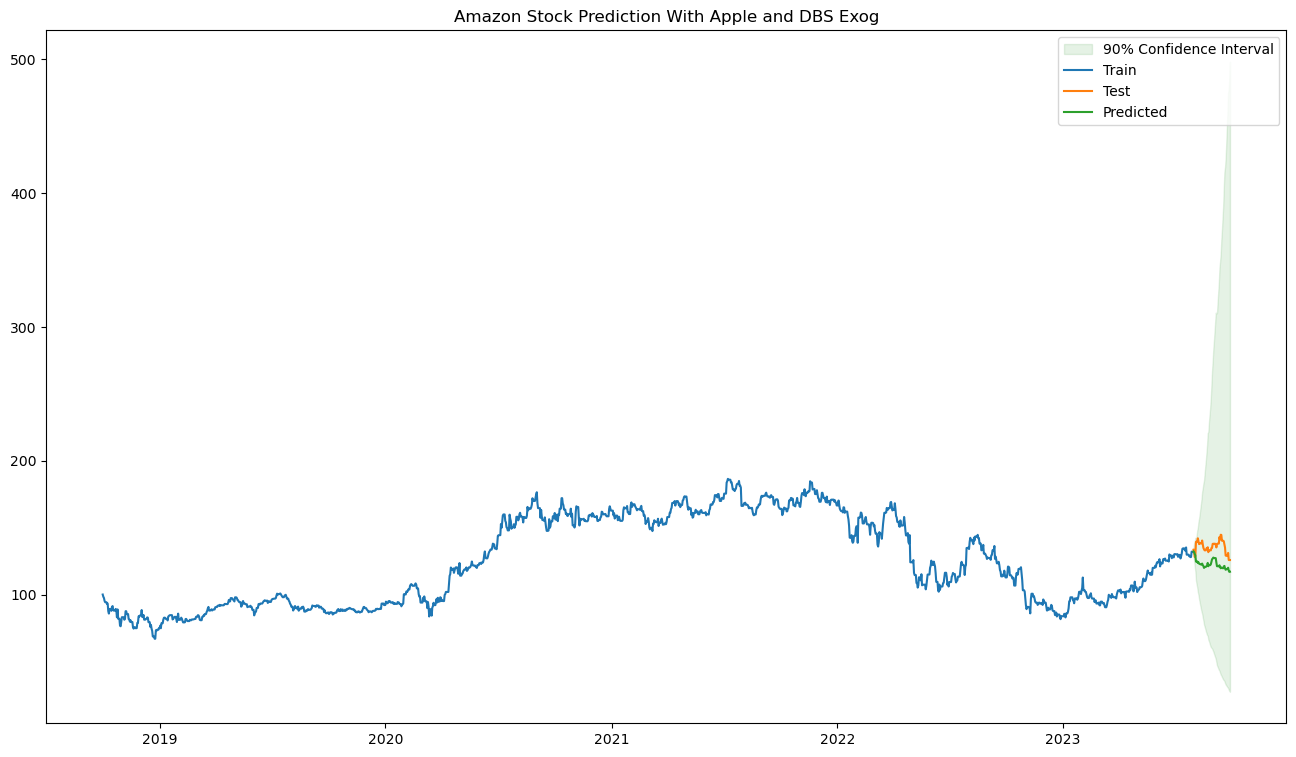

In [337]:
# Splitting the dataset for prediction
df_amazon_train_data_unmodified = df['Amazon'].iloc[:len(df['Amazon'])-60]
df_amazon_test_data_unmodified = df['Amazon'].iloc[len(df['Amazon'])-60:]

# Make predictions
predictions = amazon_with_apple_and_dbs_result.predict(start=len(df_amazon_train_data_unmodified)-1, 
                                            end=len(df_amazon_train_data_unmodified)+58, exog=exog_dataset[['Apple', 'DBS']][len(df_amazon)-60:])

forecast_ci = amazon_with_apple_and_dbs_result.get_prediction(start=len(df_amazon_train_data_unmodified)-1, 
                                            end=len(df_amazon_train_data_unmodified)+58, exog=exog_dataset[['Apple', 'DBS']][len(df_amazon)-60:]).summary_frame(alpha=0.1)

# Compare predictions with actual data
plt.figure(figsize=(16,9))
last_observed_value = df_amazon_train_data_unmodified.iloc[-1]
forecast_original = np.cumsum(np.insert(predictions, 0, np.log(last_observed_value)))[1:]
forecast_ci['mean_ci_lower'] = np.cumsum(np.insert(forecast_ci['mean_ci_lower'], 0, np.log(last_observed_value)))[1:]
forecast_ci['mean_ci_upper'] = np.cumsum(np.insert(forecast_ci['mean_ci_upper'], 0, np.log(last_observed_value)))[1:]

plt.fill_between(forecast_ci.index, np.exp(forecast_ci['mean_ci_lower']), np.exp(forecast_ci['mean_ci_upper']), color='green', alpha=0.1, label='90% Confidence Interval')
plt.plot(df_amazon_train_data_unmodified.index, df_amazon_train_data_unmodified, label='Train')
plt.plot(df_amazon_test_data_unmodified.index, df_amazon_test_data_unmodified, label='Test')
plt.plot(predictions.index, np.exp(forecast_original), label='Predicted')
plt.title('Amazon Stock Prediction With Apple and DBS Exog')
plt.legend()
plt.show()

amazon_with_apple_and_dbs['mse'] = mean_squared_error(df_amazon_test_data_unmodified, np.exp(forecast_original))

#### 3.2 Apple

In [338]:
df_apple

2018-10-02    0.008849
2018-10-03    0.012095
2018-10-04   -0.017737
2018-10-05   -0.016362
2018-10-06    0.000000
                ...   
2023-09-24    0.000000
2023-09-25    0.007353
2023-09-26   -0.023677
2023-09-27   -0.008937
2023-09-28    0.001524
Freq: D, Name: Apple, Length: 1823, dtype: float64

In [339]:
# Splitting the dataset for prediction
df_apple_train_data = df_apple.iloc[:len(df_apple)-60]
df_apple_test_data = df_apple.iloc[len(df_apple)-60:]

print(f"Percentage of training data: {(len(df_apple_train_data)/len(df_apple))*100}%")
print(f"Percentage of test data: {(len(df_apple_test_data)/len(df_apple))*100}%")

Percentage of training data: 96.70872188699946%
Percentage of test data: 3.2912781130005486%


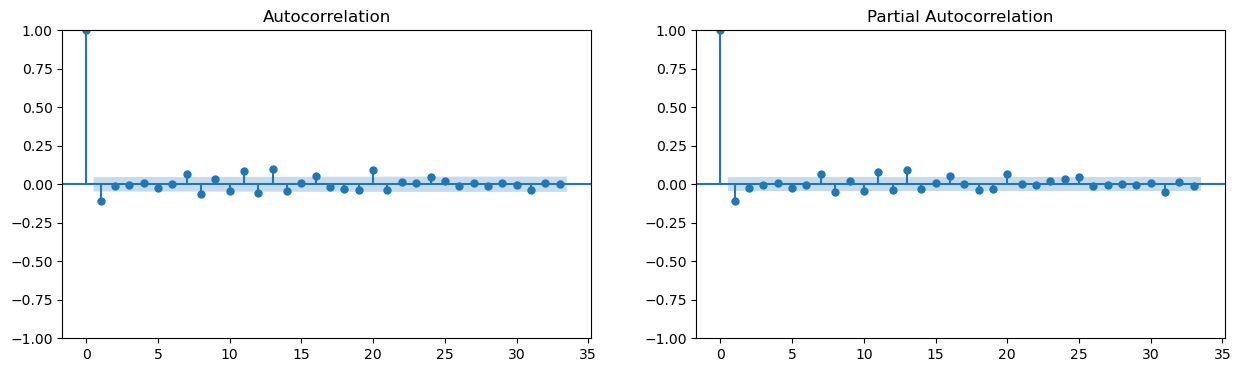

In [340]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(df_apple_train_data, ax=axes[0])
plot_pacf(df_apple_train_data, ax=axes[1])
plt.show()

##### 3.2.1 Getting MSE and best hyperparameters with Amazon as exog

In [342]:
# Grid search ranges
p_values = range(2)
d_values = range(2)
q_values = range(3)
P_values = range(3)
D_values = [1]
Q_values = [0]
s_values = [12]

apple_with_amazon = manual_arima(p_values, d_values, q_values, P_values, D_values, Q_values, s_values, df_apple_train_data, exog_dataset[['Amazon']][:len(df_apple)-60])

print(f"Best AIC: {apple_with_amazon['best_aic']}")
print(f"Best (p, d, q) order: {apple_with_amazon['best_order']}")
print(f"Best (P, D, Q, s) seasonal order: {apple_with_amazon['best_seasonal_order']}")

Completed 1/48 (0, 0, 0) with seasonal order (2, 1, 0, 12)
Completed 2/48 (0, 0, 0) with seasonal order (2, 1, 1, 12)
Completed 3/48 (0, 0, 0) with seasonal order (3, 1, 0, 12)
Completed 4/48 (0, 0, 0) with seasonal order (3, 1, 1, 12)
Completed 5/48 (0, 0, 1) with seasonal order (2, 1, 0, 12)
Completed 6/48 (0, 0, 1) with seasonal order (2, 1, 1, 12)
Completed 7/48 (0, 0, 1) with seasonal order (3, 1, 0, 12)
Completed 8/48 (0, 0, 1) with seasonal order (3, 1, 1, 12)
Completed 9/48 (0, 0, 2) with seasonal order (2, 1, 0, 12)
Completed 10/48 (0, 0, 2) with seasonal order (2, 1, 1, 12)
Completed 11/48 (0, 0, 2) with seasonal order (3, 1, 0, 12)
Completed 12/48 (0, 0, 2) with seasonal order (3, 1, 1, 12)
Completed 13/48 (0, 1, 0) with seasonal order (2, 1, 0, 12)
Completed 14/48 (0, 1, 0) with seasonal order (2, 1, 1, 12)
Completed 15/48 (0, 1, 0) with seasonal order (3, 1, 0, 12)
Completed 16/48 (0, 1, 0) with seasonal order (3, 1, 1, 12)
Completed 17/48 (0, 1, 1) with seasonal order (2,

In [343]:
apple_with_amazon_model = SARIMAX(df_apple_train_data, order=apple_with_amazon['best_order'], seasonal_order=apple_with_amazon['best_seasonal_order'], exog=exog_dataset[['Amazon']][:len(df_apple)-60])
apple_with_amazon_result = apple_with_amazon_model.fit()

print(apple_with_amazon_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Apple   No. Observations:                 1763
Model:             SARIMAX(0, 0, 1)x(2, 1, 1, 12)   Log Likelihood                5057.362
Date:                            Fri, 09 Feb 2024   AIC                         -10102.725
Time:                                    16:44:17   BIC                         -10069.917
Sample:                                10-02-2018   HQIC                        -10090.597
                                     - 07-30-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Amazon         0.5831      0.008     75.644      0.000       0.568       0.598
ma.L1         -0.0557      0.020   

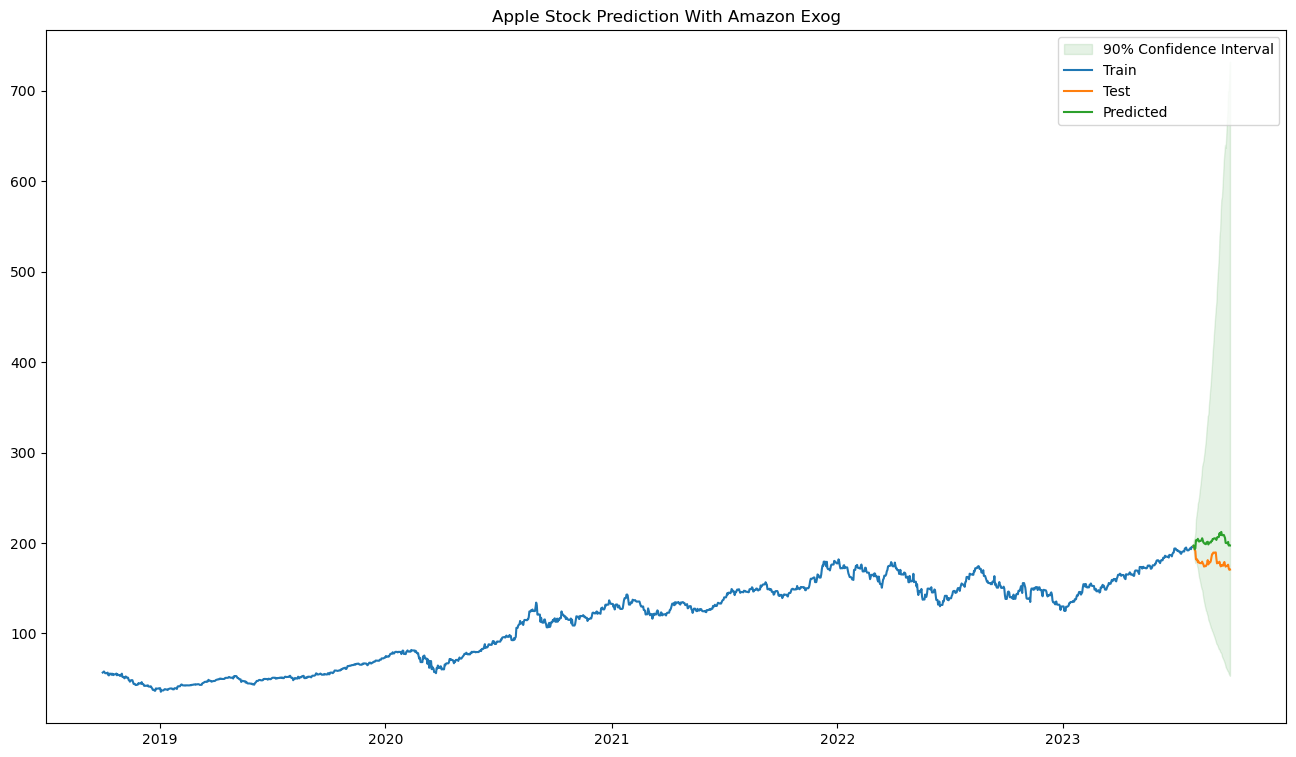

In [344]:
# Splitting the dataset for prediction
df_apple_train_data_unmodified = df['Apple'].iloc[:len(df['Apple'])-60]
df_apple_test_data_unmodified = df['Apple'].iloc[len(df['Apple'])-60:]

# Make predictions
predictions = apple_with_amazon_result.predict(start=len(df_apple_train_data_unmodified)-1, 
                                            end=len(df_apple_train_data_unmodified)+58, exog=exog_dataset[['Amazon']][len(df_apple)-60:])

forecast_ci = apple_with_amazon_result.get_prediction(start=len(df_apple_train_data_unmodified)-1, 
                                            end=len(df_apple_train_data_unmodified)+58, exog=exog_dataset[['Amazon']][len(df_apple)-60:]).summary_frame(alpha=0.1)

# Compare predictions with actual data
plt.figure(figsize=(16,9))
last_observed_value = df_apple_train_data_unmodified.iloc[-1]
forecast_original = np.cumsum(np.insert(predictions, 0, np.log(last_observed_value)))[1:]
forecast_ci['mean_ci_lower'] = np.cumsum(np.insert(forecast_ci['mean_ci_lower'], 0, np.log(last_observed_value)))[1:]
forecast_ci['mean_ci_upper'] = np.cumsum(np.insert(forecast_ci['mean_ci_upper'], 0, np.log(last_observed_value)))[1:]

plt.fill_between(forecast_ci.index, np.exp(forecast_ci['mean_ci_lower']), np.exp(forecast_ci['mean_ci_upper']), color='green', alpha=0.1, label='90% Confidence Interval')
plt.plot(df_apple_train_data_unmodified.index, df_apple_train_data_unmodified, label='Train')
plt.plot(df_apple_test_data_unmodified.index, df_apple_test_data_unmodified, label='Test')
plt.plot(predictions.index, np.exp(forecast_original), label='Predicted')

plt.title('Apple Stock Prediction With Amazon Exog')
plt.legend()
plt.show()

apple_with_amazon['mse'] = mean_squared_error(df_apple_test_data_unmodified, np.exp(forecast_original))

##### 3.2.2 Getting MSE and best hyperparameters with DBS as exog

In [347]:
# Grid search ranges
p_values = range(2)
d_values = range(2)
q_values = range(3)
P_values = range(3)
D_values = [1]
Q_values = [0]
s_values = [12]

apple_with_dbs = manual_arima(p_values, d_values, q_values, P_values, D_values, Q_values, s_values, df_apple_train_data, exog_dataset[['DBS']][:len(df_apple)-60])

print(f"Best AIC: {apple_with_dbs['best_aic']}")
print(f"Best (p, d, q) order: {apple_with_dbs['best_order']}")
print(f"Best (P, D, Q, s) seasonal order: {apple_with_dbs['best_seasonal_order']}")

Completed 1/36 (0, 0, 0) with seasonal order (0, 1, 0, 12)
Completed 2/36 (0, 0, 0) with seasonal order (1, 1, 0, 12)
Completed 3/36 (0, 0, 0) with seasonal order (2, 1, 0, 12)
Completed 4/36 (0, 0, 1) with seasonal order (0, 1, 0, 12)
Completed 5/36 (0, 0, 1) with seasonal order (1, 1, 0, 12)
Completed 6/36 (0, 0, 1) with seasonal order (2, 1, 0, 12)
Completed 7/36 (0, 0, 2) with seasonal order (0, 1, 0, 12)
Completed 8/36 (0, 0, 2) with seasonal order (1, 1, 0, 12)
Completed 9/36 (0, 0, 2) with seasonal order (2, 1, 0, 12)
Completed 10/36 (0, 1, 0) with seasonal order (0, 1, 0, 12)
Completed 11/36 (0, 1, 0) with seasonal order (1, 1, 0, 12)
Completed 12/36 (0, 1, 0) with seasonal order (2, 1, 0, 12)
Completed 13/36 (0, 1, 1) with seasonal order (0, 1, 0, 12)
Completed 14/36 (0, 1, 1) with seasonal order (1, 1, 0, 12)
Completed 15/36 (0, 1, 1) with seasonal order (2, 1, 0, 12)
Completed 16/36 (0, 1, 2) with seasonal order (0, 1, 0, 12)
Completed 17/36 (0, 1, 2) with seasonal order (1,

In [348]:
apple_with_dbs_model = SARIMAX(df_apple_train_data, order=apple_with_dbs['best_order'], seasonal_order=apple_with_dbs['best_seasonal_order'], exog=exog_dataset[['DBS']][:len(df_apple)-60])
apple_with_dbs_result = apple_with_dbs_model.fit()

print(apple_with_dbs_result.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Apple   No. Observations:                 1763
Model:             SARIMAX(0, 0, 1)x(2, 1, [], 12)   Log Likelihood                4352.059
Date:                             Fri, 09 Feb 2024   AIC                          -8694.118
Time:                                     16:53:46   BIC                          -8666.779
Sample:                                 10-02-2018   HQIC                         -8684.012
                                      - 07-30-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
DBS            0.0624      0.027      2.344      0.019       0.010       0.115
ma.L1         -0.1423      

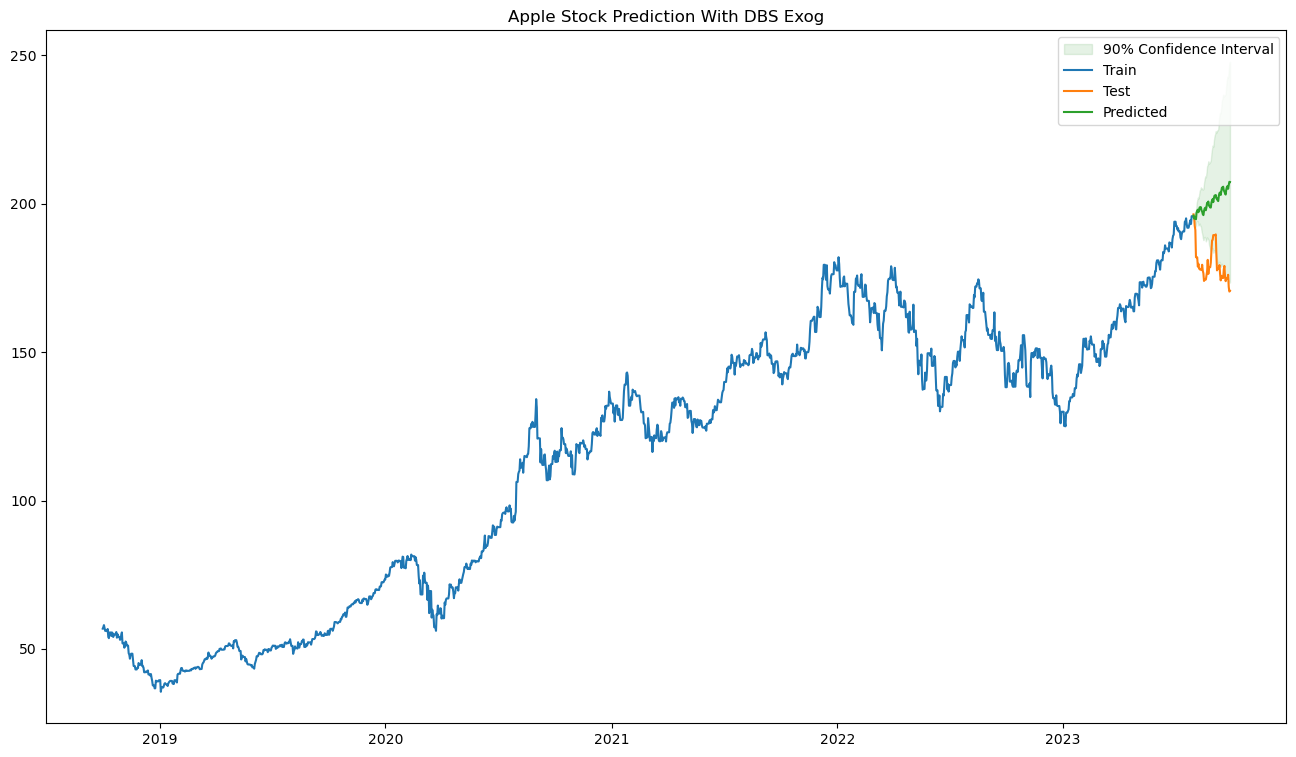

In [351]:
# Splitting the dataset for prediction
df_apple_train_data_unmodified = df['Apple'].iloc[:len(df['Apple'])-60]
df_apple_test_data_unmodified = df['Apple'].iloc[len(df['Apple'])-60:]

# Make predictions
predictions = apple_with_dbs_result.predict(start=len(df_apple_train_data_unmodified)-1, 
                                            end=len(df_apple_train_data_unmodified)+58, exog=exog_dataset[['DBS']][len(df_apple)-60:])

forecast_ci = apple_with_dbs_result.get_prediction(start=len(df_apple_train_data_unmodified)-1, 
                                            end=len(df_apple_train_data_unmodified)+58, exog=exog_dataset[['DBS']][len(df_apple)-60:]).summary_frame(alpha=0.1)

# Compare predictions with actual data
plt.figure(figsize=(16,9))
last_observed_value = df_apple_train_data_unmodified.iloc[-1]
forecast_original = np.cumsum(np.insert(predictions, 0, np.log(last_observed_value)))[1:]
forecast_ci['mean_ci_lower'] = np.cumsum(np.insert(forecast_ci['mean_ci_lower'], 0, np.log(last_observed_value)))[1:]
forecast_ci['mean_ci_upper'] = np.cumsum(np.insert(forecast_ci['mean_ci_upper'], 0, np.log(last_observed_value)))[1:]

plt.fill_between(forecast_ci.index, np.exp(forecast_ci['mean_ci_lower']), np.exp(forecast_ci['mean_ci_upper']), color='green', alpha=0.1, label='90% Confidence Interval')
plt.plot(df_apple_train_data_unmodified.index, df_apple_train_data_unmodified, label='Train')
plt.plot(df_apple_test_data_unmodified.index, df_apple_test_data_unmodified, label='Test')
plt.plot(predictions.index, np.exp(forecast_original), label='Predicted')

plt.title('Apple Stock Prediction With DBS Exog')
plt.legend()
plt.show()

apple_with_dbs['mse'] = mean_squared_error(df_apple_test_data_unmodified, np.exp(forecast_original))

##### 3.2.3 Getting MSE and best hyperparameters with Amazon and DBS as exog

In [352]:
# Grid search ranges
p_values = range(2)
d_values = range(2)
q_values = range(3)
P_values = range(3)
D_values = [1]
Q_values = [0]
s_values = [12]

apple_with_amazon_and_dbs = manual_arima(p_values, d_values, q_values, P_values, D_values, Q_values, s_values, df_apple_train_data, exog_dataset[['Amazon', 'DBS']][:len(df_apple)-60])

print(f"Best AIC: {apple_with_amazon_and_dbs['best_aic']}")
print(f"Best (p, d, q) order: {apple_with_amazon_and_dbs['best_order']}")
print(f"Best (P, D, Q, s) seasonal order: {apple_with_amazon_and_dbs['best_seasonal_order']}")

Completed 1/36 (0, 0, 0) with seasonal order (0, 1, 0, 12)
Completed 2/36 (0, 0, 0) with seasonal order (1, 1, 0, 12)
Completed 3/36 (0, 0, 0) with seasonal order (2, 1, 0, 12)
Completed 4/36 (0, 0, 1) with seasonal order (0, 1, 0, 12)
Completed 5/36 (0, 0, 1) with seasonal order (1, 1, 0, 12)
Completed 6/36 (0, 0, 1) with seasonal order (2, 1, 0, 12)
Completed 7/36 (0, 0, 2) with seasonal order (0, 1, 0, 12)
Completed 8/36 (0, 0, 2) with seasonal order (1, 1, 0, 12)
Completed 9/36 (0, 0, 2) with seasonal order (2, 1, 0, 12)
Completed 10/36 (0, 1, 0) with seasonal order (0, 1, 0, 12)
Completed 11/36 (0, 1, 0) with seasonal order (1, 1, 0, 12)
Completed 12/36 (0, 1, 0) with seasonal order (2, 1, 0, 12)
Completed 13/36 (0, 1, 1) with seasonal order (0, 1, 0, 12)
Completed 14/36 (0, 1, 1) with seasonal order (1, 1, 0, 12)
Completed 15/36 (0, 1, 1) with seasonal order (2, 1, 0, 12)
Completed 16/36 (0, 1, 2) with seasonal order (0, 1, 0, 12)
Completed 17/36 (0, 1, 2) with seasonal order (1,

In [353]:
apple_with_amazon_and_dbs_model = SARIMAX(df_apple_train_data, order=apple_with_amazon_and_dbs['best_order'], seasonal_order=apple_with_amazon_and_dbs['best_seasonal_order'], exog=exog_dataset[['Amazon', 'DBS']][:len(df_apple)-60])
apple_with_amazon_and_dbs_result = apple_with_amazon_and_dbs_model.fit()

print(apple_with_amazon_and_dbs_result.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Apple   No. Observations:                 1763
Model:             SARIMAX(0, 0, 1)x(2, 1, [], 12)   Log Likelihood                4838.406
Date:                             Fri, 09 Feb 2024   AIC                          -9664.812
Time:                                     16:58:34   BIC                          -9632.004
Sample:                                 10-02-2018   HQIC                         -9652.685
                                      - 07-30-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Amazon         0.5941      0.009     67.193      0.000       0.577       0.611
DBS            0.0063      

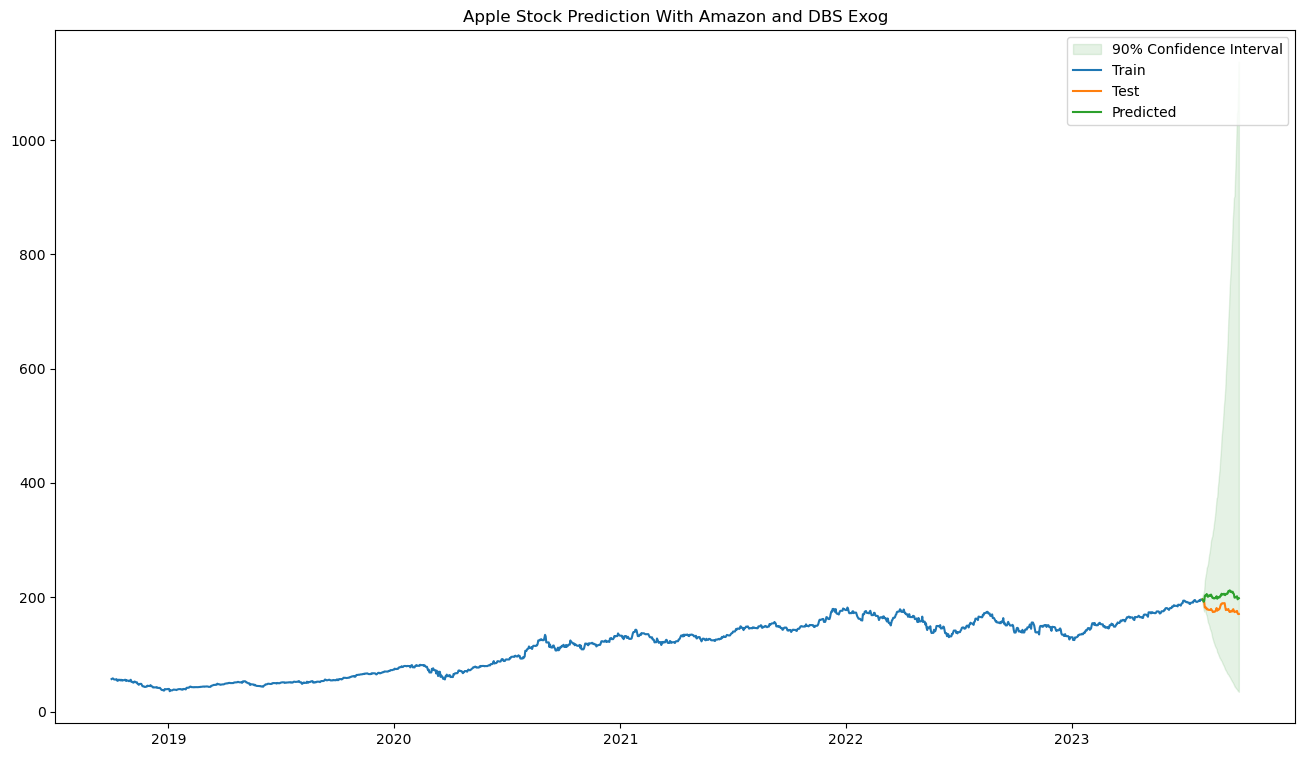

In [355]:
# Splitting the dataset for prediction
df_apple_train_data_unmodified = df['Apple'].iloc[:len(df['Apple'])-60]
df_apple_test_data_unmodified = df['Apple'].iloc[len(df['Apple'])-60:]

# Make predictions
predictions = apple_with_amazon_and_dbs_result.predict(start=len(df_apple_train_data_unmodified)-1, 
                                            end=len(df_apple_train_data_unmodified)+58, exog=exog_dataset[['Amazon', 'DBS']][len(df_apple)-60:])

forecast_ci = apple_with_amazon_and_dbs_result.get_prediction(start=len(df_apple_train_data_unmodified)-1, 
                                            end=len(df_apple_train_data_unmodified)+58, exog=exog_dataset[['Amazon', 'DBS']][len(df_apple)-60:]).summary_frame(alpha=0.1)

# Compare predictions with actual data
plt.figure(figsize=(16,9))
last_observed_value = df_apple_train_data_unmodified.iloc[-1]
forecast_original = np.cumsum(np.insert(predictions, 0, np.log(last_observed_value)))[1:]
forecast_ci['mean_ci_lower'] = np.cumsum(np.insert(forecast_ci['mean_ci_lower'], 0, np.log(last_observed_value)))[1:]
forecast_ci['mean_ci_upper'] = np.cumsum(np.insert(forecast_ci['mean_ci_upper'], 0, np.log(last_observed_value)))[1:]

plt.fill_between(forecast_ci.index, np.exp(forecast_ci['mean_ci_lower']), np.exp(forecast_ci['mean_ci_upper']), color='green', alpha=0.1, label='90% Confidence Interval')
plt.plot(df_apple_train_data_unmodified.index, df_apple_train_data_unmodified, label='Train')
plt.plot(df_apple_test_data_unmodified.index, df_apple_test_data_unmodified, label='Test')
plt.plot(predictions.index, np.exp(forecast_original), label='Predicted')

plt.title('Apple Stock Prediction With Amazon and DBS Exog')
plt.legend()
plt.show()

apple_with_amazon_and_dbs['mse'] = mean_squared_error(df_apple_test_data_unmodified, np.exp(forecast_original))

#### 3.3 DBS

In [356]:
df_dbs

2018-10-02   -0.013178
2018-10-03    0.012408
2018-10-04   -0.007349
2018-10-05    0.000388
2018-10-06    0.000000
                ...   
2023-09-24    0.000000
2023-09-25    0.005997
2023-09-26    0.001792
2023-09-27   -0.002390
2023-09-28    0.002092
Freq: D, Name: DBS, Length: 1823, dtype: float64

In [357]:
# Splitting the dataset for prediction
df_dbs_train_data = df_dbs.iloc[:len(df_dbs)-60]
df_dbs_test_data = df_dbs.iloc[len(df_dbs)-60:]

print(f"Percentage of training data: {(len(df_dbs_train_data)/len(df_dbs))*100}%")
print(f"Percentage of test data: {(len(df_dbs_test_data)/len(df_dbs))*100}%")

Percentage of training data: 96.70872188699946%
Percentage of test data: 3.2912781130005486%


Plotting the PACF and ACF plot

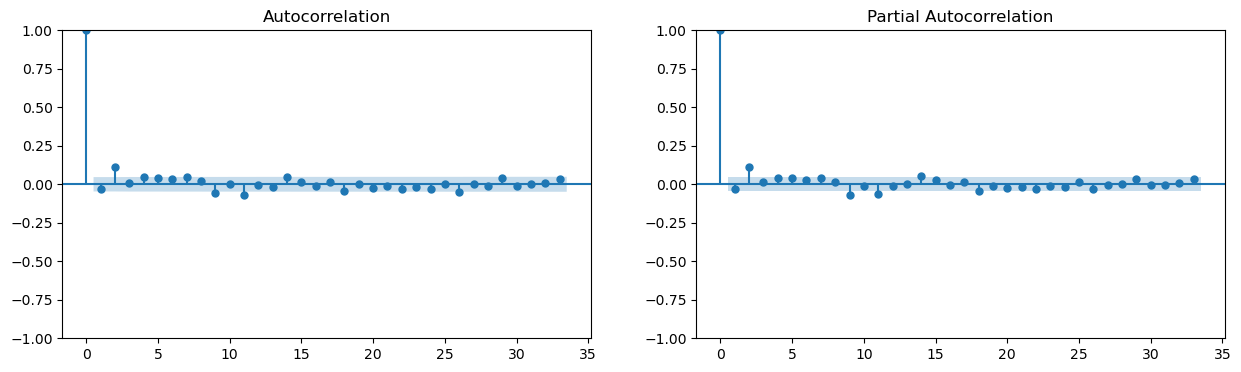

In [358]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(df_dbs_train_data, ax=axes[0])
plot_pacf(df_dbs_train_data, ax=axes[1])
plt.show()

##### 3.3.1 Getting MSE and best hyperparameters with Amazon as exog

In [362]:
# Grid search ranges
p_values = range(2)
d_values = range(2)
q_values = range(2)
P_values = range(2)
D_values = [1]
Q_values = range(2,4)
s_values = [12]  # Assuming monthly data

dbs_with_amazon = manual_arima(p_values, d_values, q_values, P_values, D_values, Q_values, s_values, df_dbs_train_data, exog_dataset[['Amazon']][:len(df_dbs)-60])

print(f"Best AIC: {dbs_with_amazon['best_aic']}")
print(f"Best (p, d, q) order: {dbs_with_amazon['best_order']}")
print(f"Best (P, D, Q, s) seasonal order: {dbs_with_amazon['best_seasonal_order']}")

Completed 1/32 (0, 0, 0) with seasonal order (0, 1, 2, 12)
Completed 2/32 (0, 0, 0) with seasonal order (0, 1, 3, 12)
Completed 3/32 (0, 0, 0) with seasonal order (1, 1, 2, 12)
Completed 4/32 (0, 0, 0) with seasonal order (1, 1, 3, 12)
Completed 5/32 (0, 0, 1) with seasonal order (0, 1, 2, 12)
Completed 6/32 (0, 0, 1) with seasonal order (0, 1, 3, 12)
Completed 7/32 (0, 0, 1) with seasonal order (1, 1, 2, 12)
Completed 8/32 (0, 0, 1) with seasonal order (1, 1, 3, 12)
Completed 9/32 (0, 1, 0) with seasonal order (0, 1, 2, 12)
Completed 10/32 (0, 1, 0) with seasonal order (0, 1, 3, 12)
Completed 11/32 (0, 1, 0) with seasonal order (1, 1, 2, 12)
Completed 12/32 (0, 1, 0) with seasonal order (1, 1, 3, 12)
Completed 13/32 (0, 1, 1) with seasonal order (0, 1, 2, 12)
Completed 14/32 (0, 1, 1) with seasonal order (0, 1, 3, 12)
Completed 15/32 (0, 1, 1) with seasonal order (1, 1, 2, 12)
Completed 16/32 (0, 1, 1) with seasonal order (1, 1, 3, 12)
Completed 17/32 (1, 0, 0) with seasonal order (0,

In [363]:
dbs_with_amazon_model = SARIMAX(df_dbs_train_data, order=dbs_with_amazon['best_order'], seasonal_order=dbs_with_amazon['best_seasonal_order'], exog=exog_dataset[['Amazon']][:len(df_dbs)-60])
dbs_with_amazon_result = dbs_with_amazon_model.fit()

print(dbs_with_amazon_result.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                     DBS   No. Observations:                 1763
Model:             SARIMAX(1, 0, 1)x(1, 1, [1, 2], 12)   Log Likelihood                5463.019
Date:                                 Fri, 09 Feb 2024   AIC                         -10912.038
Time:                                         17:28:51   BIC                         -10873.762
Sample:                                     10-02-2018   HQIC                        -10897.889
                                          - 07-30-2023                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Amazon         0.0218      0.009      2.401      0.016       0.004       0

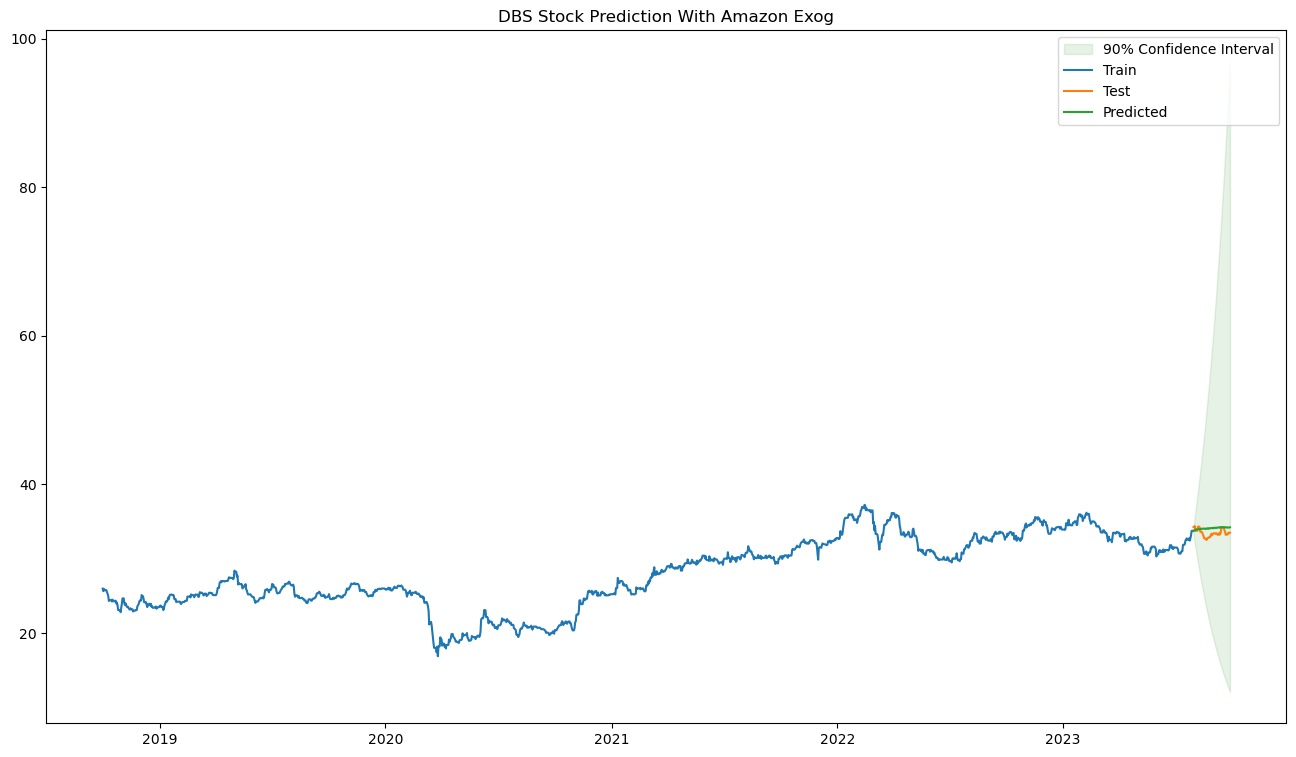

In [364]:
# Splitting the dataset for prediction
df_dbs_train_data_unmodified = df['DBS'].iloc[:len(df['DBS'])-60]
df_dbs_test_data_unmodified = df['DBS'].iloc[len(df['DBS'])-60:]

# Make predictions
predictions = dbs_with_amazon_result.predict(start=len(df_dbs_train_data_unmodified)-1, 
                                            end=len(df_dbs_train_data_unmodified)+58, exog=exog_dataset[['Amazon']][len(df_dbs)-60:])

forecast_ci = dbs_with_amazon_result.get_prediction(start=len(df_dbs_train_data_unmodified)-1, 
                                            end=len(df_dbs_train_data_unmodified)+58, exog=exog_dataset[['Amazon']][len(df_dbs)-60:]).summary_frame(alpha=0.1)

# Compare predictions with actual data
plt.figure(figsize=(16,9))
last_observed_value = df_dbs_train_data_unmodified.iloc[-1]
forecast_original = np.cumsum(np.insert(predictions, 0, np.log(last_observed_value)))[1:]
forecast_ci['mean_ci_lower'] = np.cumsum(np.insert(forecast_ci['mean_ci_lower'], 0, np.log(last_observed_value)))[1:]
forecast_ci['mean_ci_upper'] = np.cumsum(np.insert(forecast_ci['mean_ci_upper'], 0, np.log(last_observed_value)))[1:]

plt.fill_between(forecast_ci.index, np.exp(forecast_ci['mean_ci_lower']), np.exp(forecast_ci['mean_ci_upper']), color='green', alpha=0.1, label='90% Confidence Interval')
plt.plot(df_dbs_train_data_unmodified.index, df_dbs_train_data_unmodified, label='Train')
plt.plot(df_dbs_test_data_unmodified.index, df_dbs_test_data_unmodified, label='Test')
plt.plot(predictions.index, np.exp(forecast_original), label='Predicted')
plt.title('DBS Stock Prediction With Amazon Exog')
plt.legend()
plt.show()

dbs_with_amazon['mse'] = mean_squared_error(df_dbs_test_data_unmodified, np.exp(forecast_original))

##### 3.3.2 Getting MSE and best hyperparameters with Apple as exog

In [365]:
# Grid search ranges
p_values = range(2)
d_values = range(2)
q_values = range(2)
P_values = range(2)
D_values = [1]
Q_values = range(2,4)
s_values = [12]  # Assuming monthly data

dbs_with_apple = manual_arima(p_values, d_values, q_values, P_values, D_values, Q_values, s_values, df_dbs_train_data, exog_dataset[['Apple']][:len(df_dbs)-60])

print(f"Best AIC: {dbs_with_apple['best_aic']}")
print(f"Best (p, d, q) order: {dbs_with_apple['best_order']}")
print(f"Best (P, D, Q, s) seasonal order: {dbs_with_apple['best_seasonal_order']}")

Completed 1/32 (0, 0, 0) with seasonal order (0, 1, 2, 12)
Completed 2/32 (0, 0, 0) with seasonal order (0, 1, 3, 12)
Completed 3/32 (0, 0, 0) with seasonal order (1, 1, 2, 12)
Completed 4/32 (0, 0, 0) with seasonal order (1, 1, 3, 12)
Completed 5/32 (0, 0, 1) with seasonal order (0, 1, 2, 12)
Completed 6/32 (0, 0, 1) with seasonal order (0, 1, 3, 12)
Completed 7/32 (0, 0, 1) with seasonal order (1, 1, 2, 12)
Completed 8/32 (0, 0, 1) with seasonal order (1, 1, 3, 12)
Completed 9/32 (0, 1, 0) with seasonal order (0, 1, 2, 12)
Completed 10/32 (0, 1, 0) with seasonal order (0, 1, 3, 12)
Completed 11/32 (0, 1, 0) with seasonal order (1, 1, 2, 12)
Completed 12/32 (0, 1, 0) with seasonal order (1, 1, 3, 12)
Completed 13/32 (0, 1, 1) with seasonal order (0, 1, 2, 12)
Completed 14/32 (0, 1, 1) with seasonal order (0, 1, 3, 12)
Completed 15/32 (0, 1, 1) with seasonal order (1, 1, 2, 12)
Completed 16/32 (0, 1, 1) with seasonal order (1, 1, 3, 12)
Completed 17/32 (1, 0, 0) with seasonal order (0,

In [366]:
dbs_with_apple_model = SARIMAX(df_dbs_train_data, order=dbs_with_apple['best_order'], seasonal_order=dbs_with_apple['best_seasonal_order'], exog=exog_dataset[['Apple']][:len(df_dbs)-60])
dbs_with_apple_result = dbs_with_apple_model.fit()

print(dbs_with_apple_result.summary())

                                   SARIMAX Results                                   
Dep. Variable:                           DBS   No. Observations:                 1763
Model:             SARIMAX(0, 1, [1, 2], 12)   Log Likelihood                5459.071
Date:                       Fri, 09 Feb 2024   AIC                         -10910.141
Time:                               18:53:20   BIC                         -10888.269
Sample:                           10-02-2018   HQIC                        -10902.056
                                - 07-30-2023                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Apple          0.0209      0.008      2.692      0.007       0.006       0.036
ma.S.L12      -1.0053      0.135     -7.456      0.000      -1.270      -0.

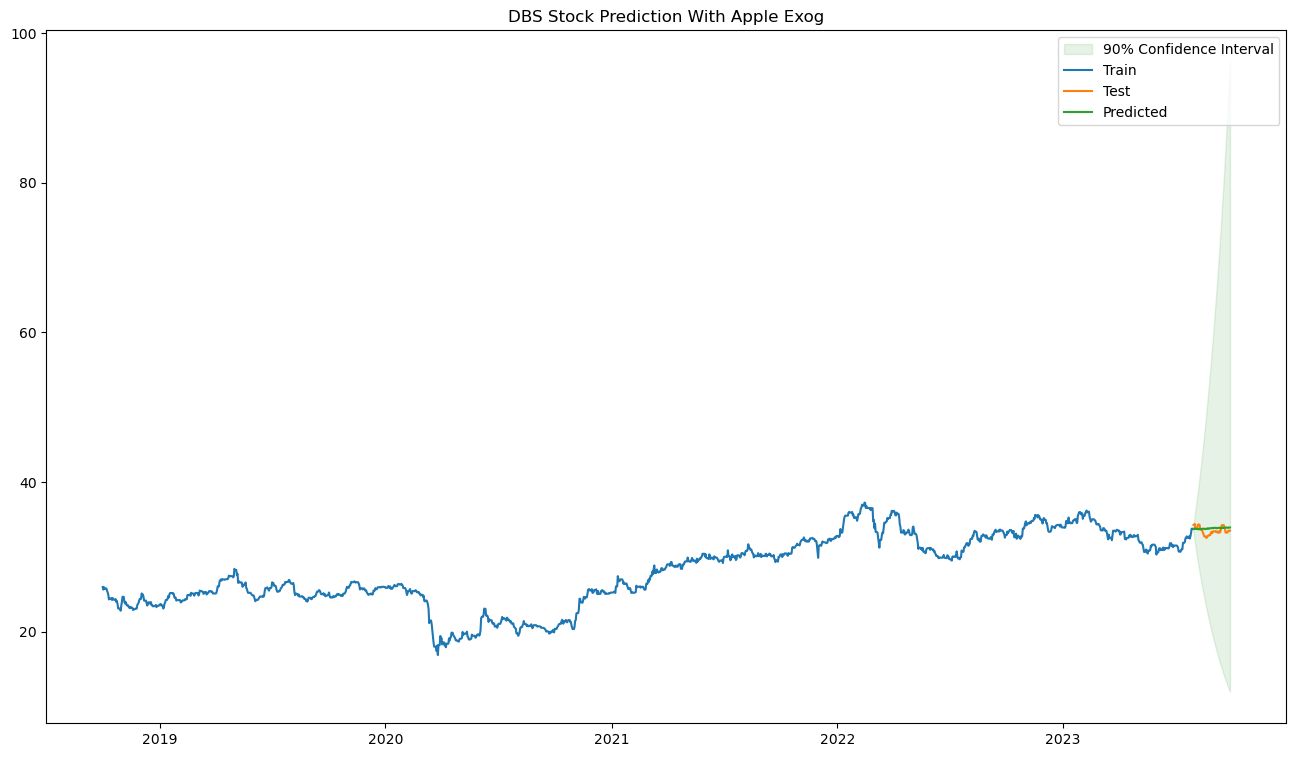

In [367]:
# Splitting the dataset for prediction
df_dbs_train_data_unmodified = df['DBS'].iloc[:len(df['DBS'])-60]
df_dbs_test_data_unmodified = df['DBS'].iloc[len(df['DBS'])-60:]

# Make predictions
predictions = dbs_with_apple_result.predict(start=len(df_dbs_train_data_unmodified)-1, 
                                            end=len(df_dbs_train_data_unmodified)+58, exog=exog_dataset[['Apple']][len(df_dbs)-60:])

forecast_ci = dbs_with_apple_result.get_prediction(start=len(df_dbs_train_data_unmodified)-1, 
                                            end=len(df_dbs_train_data_unmodified)+58, exog=exog_dataset[['Apple']][len(df_dbs)-60:]).summary_frame(alpha=0.1)

# Compare predictions with actual data
plt.figure(figsize=(16,9))
last_observed_value = df_dbs_train_data_unmodified.iloc[-1]
forecast_original = np.cumsum(np.insert(predictions, 0, np.log(last_observed_value)))[1:]
forecast_ci['mean_ci_lower'] = np.cumsum(np.insert(forecast_ci['mean_ci_lower'], 0, np.log(last_observed_value)))[1:]
forecast_ci['mean_ci_upper'] = np.cumsum(np.insert(forecast_ci['mean_ci_upper'], 0, np.log(last_observed_value)))[1:]

plt.fill_between(forecast_ci.index, np.exp(forecast_ci['mean_ci_lower']), np.exp(forecast_ci['mean_ci_upper']), color='green', alpha=0.1, label='90% Confidence Interval')
plt.plot(df_dbs_train_data_unmodified.index, df_dbs_train_data_unmodified, label='Train')
plt.plot(df_dbs_test_data_unmodified.index, df_dbs_test_data_unmodified, label='Test')
plt.plot(predictions.index, np.exp(forecast_original), label='Predicted')
plt.title('DBS Stock Prediction With Apple Exog')
plt.legend()
plt.show()

dbs_with_apple['mse'] = mean_squared_error(df_dbs_test_data_unmodified, np.exp(forecast_original))

##### 3.3.3 Getting MSE and best hyperparameters with Amazon and Apple as exog

In [368]:
# Grid search ranges
p_values = range(2)
d_values = range(2)
q_values = range(2)
P_values = range(2)
D_values = [1]
Q_values = range(2,4)
s_values = [12]  # Assuming monthly data

dbs_with_amazon_and_apple = manual_arima(p_values, d_values, q_values, P_values, D_values, Q_values, s_values, df_dbs_train_data, exog_dataset[['Amazon', 'Apple']][:len(df_dbs)-60])

print(f"Best AIC: {dbs_with_amazon_and_apple['best_aic']}")
print(f"Best (p, d, q) order: {dbs_with_amazon_and_apple['best_order']}")
print(f"Best (P, D, Q, s) seasonal order: {dbs_with_amazon_and_apple['best_seasonal_order']}")

Completed 1/32 (0, 0, 0) with seasonal order (0, 1, 2, 12)
Completed 2/32 (0, 0, 0) with seasonal order (0, 1, 3, 12)
Completed 3/32 (0, 0, 0) with seasonal order (1, 1, 2, 12)
Completed 4/32 (0, 0, 0) with seasonal order (1, 1, 3, 12)
Completed 5/32 (0, 0, 1) with seasonal order (0, 1, 2, 12)
Completed 6/32 (0, 0, 1) with seasonal order (0, 1, 3, 12)
Completed 7/32 (0, 0, 1) with seasonal order (1, 1, 2, 12)
Completed 8/32 (0, 0, 1) with seasonal order (1, 1, 3, 12)
Completed 9/32 (0, 1, 0) with seasonal order (0, 1, 2, 12)
Completed 10/32 (0, 1, 0) with seasonal order (0, 1, 3, 12)
Completed 11/32 (0, 1, 0) with seasonal order (1, 1, 2, 12)
Completed 12/32 (0, 1, 0) with seasonal order (1, 1, 3, 12)
Completed 13/32 (0, 1, 1) with seasonal order (0, 1, 2, 12)
Completed 14/32 (0, 1, 1) with seasonal order (0, 1, 3, 12)
Completed 15/32 (0, 1, 1) with seasonal order (1, 1, 2, 12)
Completed 16/32 (0, 1, 1) with seasonal order (1, 1, 3, 12)
Completed 17/32 (1, 0, 0) with seasonal order (0,

In [369]:
dbs_with_amazon_and_apple_model = SARIMAX(df_dbs_train_data, order=dbs_with_amazon_and_apple['best_order'], seasonal_order=dbs_with_amazon_and_apple['best_seasonal_order'], exog=exog_dataset[['Amazon', 'Apple']][:len(df_dbs)-60])
dbs_with_amazon_and_apple_result = dbs_with_amazon_and_apple_model.fit()

print(dbs_with_amazon_and_apple_result.summary())

                                   SARIMAX Results                                   
Dep. Variable:                           DBS   No. Observations:                 1763
Model:             SARIMAX(0, 1, [1, 2], 12)   Log Likelihood                5459.541
Date:                       Fri, 09 Feb 2024   AIC                         -10909.083
Time:                               19:31:22   BIC                         -10881.743
Sample:                           10-02-2018   HQIC                        -10898.977
                                - 07-30-2023                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Amazon         0.0123      0.013      0.935      0.350      -0.013       0.038
Apple          0.0144      0.012      1.245      0.213      -0.008       0.

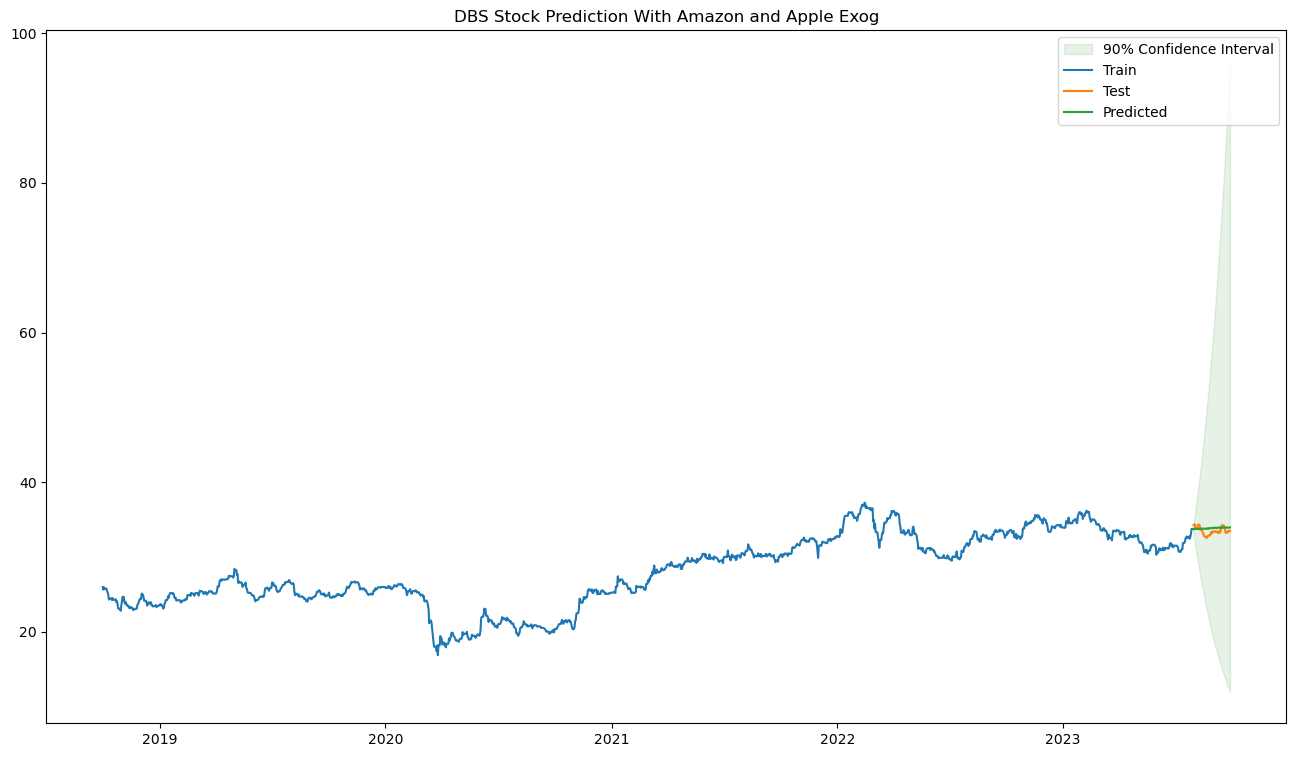

In [370]:
# Splitting the dataset for prediction
df_dbs_train_data_unmodified = df['DBS'].iloc[:len(df['DBS'])-60]
df_dbs_test_data_unmodified = df['DBS'].iloc[len(df['DBS'])-60:]

# Make predictions
predictions = dbs_with_amazon_and_apple_result.predict(start=len(df_dbs_train_data_unmodified)-1, 
                                            end=len(df_dbs_train_data_unmodified)+58, exog=exog_dataset[['Amazon', 'Apple']][len(df_dbs)-60:])

forecast_ci = dbs_with_amazon_and_apple_result.get_prediction(start=len(df_dbs_train_data_unmodified)-1, 
                                            end=len(df_dbs_train_data_unmodified)+58, exog=exog_dataset[['Amazon', 'Apple']][len(df_dbs)-60:]).summary_frame(alpha=0.1)

# Compare predictions with actual data
plt.figure(figsize=(16,9))
last_observed_value = df_dbs_train_data_unmodified.iloc[-1]
forecast_original = np.cumsum(np.insert(predictions, 0, np.log(last_observed_value)))[1:]
forecast_ci['mean_ci_lower'] = np.cumsum(np.insert(forecast_ci['mean_ci_lower'], 0, np.log(last_observed_value)))[1:]
forecast_ci['mean_ci_upper'] = np.cumsum(np.insert(forecast_ci['mean_ci_upper'], 0, np.log(last_observed_value)))[1:]

plt.fill_between(forecast_ci.index, np.exp(forecast_ci['mean_ci_lower']), np.exp(forecast_ci['mean_ci_upper']), color='green', alpha=0.1, label='90% Confidence Interval')
plt.plot(df_dbs_train_data_unmodified.index, df_dbs_train_data_unmodified, label='Train')
plt.plot(df_dbs_test_data_unmodified.index, df_dbs_test_data_unmodified, label='Test')
plt.plot(predictions.index, np.exp(forecast_original), label='Predicted')
plt.title('DBS Stock Prediction With Amazon and Apple Exog')
plt.legend()
plt.show()

dbs_with_amazon_and_apple['mse'] = mean_squared_error(df_dbs_test_data_unmodified, np.exp(forecast_original))

### 4. Choosing the best hyperparameters for each dataset

#### 4.1 Amazon

In [371]:
print(f"MSE for Amazon with Apple as exog: {amazon_with_apple['mse']}")
print(f"MSE for Amazon with DBS as exog: {amazon_with_dbs['mse']}")
print(f"MSE for Amazon with Apple and DBS as exog: {amazon_with_apple_and_dbs['mse']}")

MSE for Amazon with Apple as exog: 197.12817719350596
MSE for Amazon with DBS as exog: 30.097640571632056
MSE for Amazon with Apple and DBS as exog: 198.2775677972955


As we can see, the MSE for Amazon with DBS as the exog is the lowest. Therefore that model has the best tuned hyperparameters

In [379]:
print(f"Best AIC: {amazon_with_dbs['best_aic']}")
print(f"Best Order: {amazon_with_dbs['best_order']}")
print(f"Best Seasonal Order: {amazon_with_dbs['best_seasonal_order']}")
print(f"MSE: {amazon_with_dbs['mse']}")

Best AIC: -8801.227471886337
Best Order: (0, 0, 1)
Best Seasonal Order: (1, 1, 1, 12)
MSE: 30.097640571632056


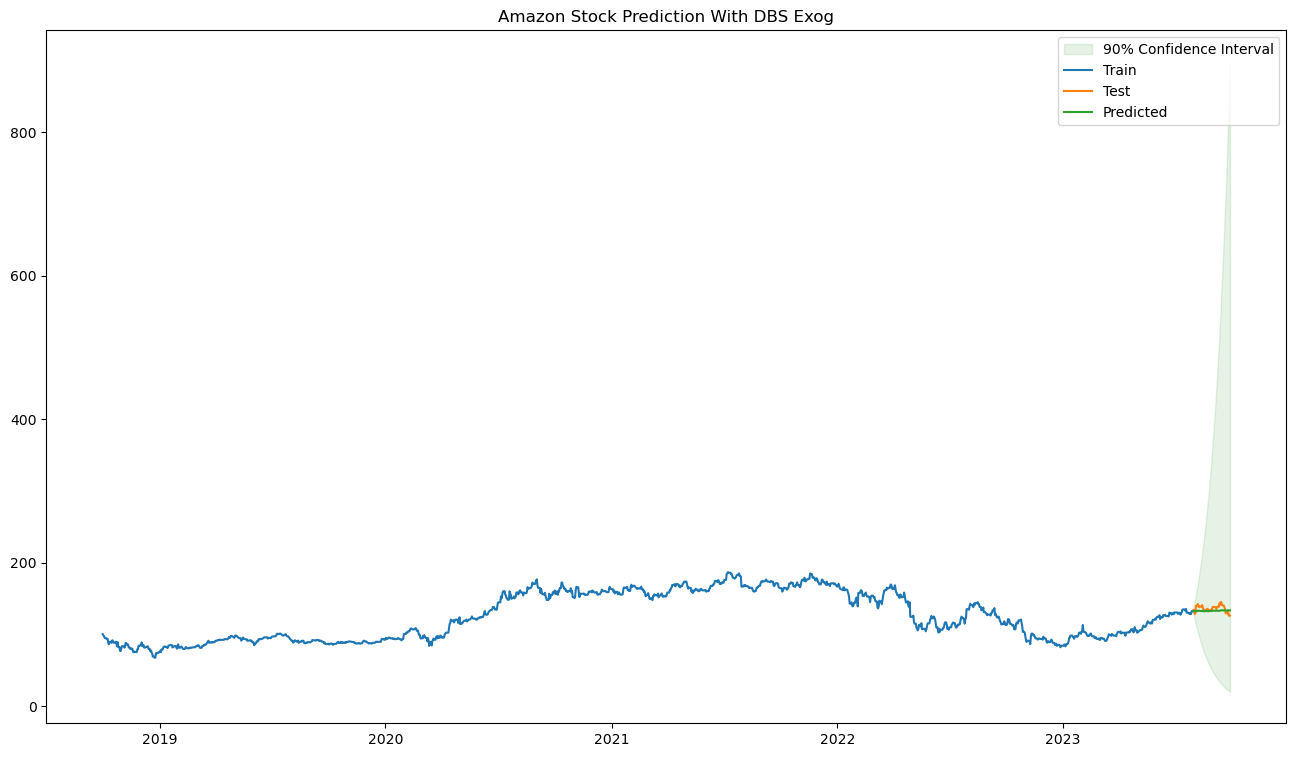

In [372]:
# Splitting the dataset for prediction
df_amazon_train_data_unmodified = df['Amazon'].iloc[:len(df['Amazon'])-60]
df_amazon_test_data_unmodified = df['Amazon'].iloc[len(df['Amazon'])-60:]

# Make predictions
predictions = amazon_with_dbs_result.predict(start=len(df_amazon_train_data_unmodified)-1, 
                                            end=len(df_amazon_train_data_unmodified)+58, exog=exog_dataset[['DBS']][len(df_amazon)-60:])

forecast_ci = amazon_with_dbs_result.get_prediction(start=len(df_amazon_train_data_unmodified)-1, 
                                            end=len(df_amazon_train_data_unmodified)+58, exog=exog_dataset[['DBS']][len(df_amazon)-60:]).summary_frame(alpha=0.1)

# Compare predictions with actual data
plt.figure(figsize=(16,9))
last_observed_value = df_amazon_train_data_unmodified.iloc[-1]
forecast_original = np.cumsum(np.insert(predictions, 0, np.log(last_observed_value)))[1:]
forecast_ci['mean_ci_lower'] = np.cumsum(np.insert(forecast_ci['mean_ci_lower'], 0, np.log(last_observed_value)))[1:]
forecast_ci['mean_ci_upper'] = np.cumsum(np.insert(forecast_ci['mean_ci_upper'], 0, np.log(last_observed_value)))[1:]

plt.fill_between(forecast_ci.index, np.exp(forecast_ci['mean_ci_lower']), np.exp(forecast_ci['mean_ci_upper']), color='green', alpha=0.1, label='90% Confidence Interval')
plt.plot(df_amazon_train_data_unmodified.index, df_amazon_train_data_unmodified, label='Train')
plt.plot(df_amazon_test_data_unmodified.index, df_amazon_test_data_unmodified, label='Test')
plt.plot(predictions.index, np.exp(forecast_original), label='Predicted')
plt.title('Amazon Stock Prediction With DBS Exog')
plt.legend()
plt.show()

Although you could argue that the predicted line isn't similar to how a stock time series would look like, it still does capture the general trend of the stock across the next 60 days which I think is more important than getting a model which predictions looks like how a stock would look like but shows an incorrect trend.

#### 4.2 Apple

In [373]:
print(f"MSE for Apple with Amazon as exog: {apple_with_amazon['mse']}")
print(f"MSE for Apple with DBS as exog: {apple_with_dbs['mse']}")
print(f"MSE for Apple with Amazon and DBS as exog: {apple_with_amazon_and_dbs['mse']}")

MSE for Apple with Amazon as exog: 595.0814477785556
MSE for Apple with DBS as exog: 512.3555046586068
MSE for Apple with Amazon and DBS as exog: 589.2615394363035


As we can see, the MSE for Apple with DBS as the exog is the lowest. Therefore that model has the best tuned hyperparameters

In [380]:
print(f"Best AIC: {apple_with_dbs['best_aic']}")
print(f"Best Order: {apple_with_dbs['best_order']}")
print(f"Best Seasonal Order: {apple_with_dbs['best_seasonal_order']}")
print(f"MSE: {apple_with_dbs['mse']}")

Best AIC: -8694.118224587724
Best Order: (0, 0, 1)
Best Seasonal Order: (2, 1, 0, 12)
MSE: 512.3555046586068


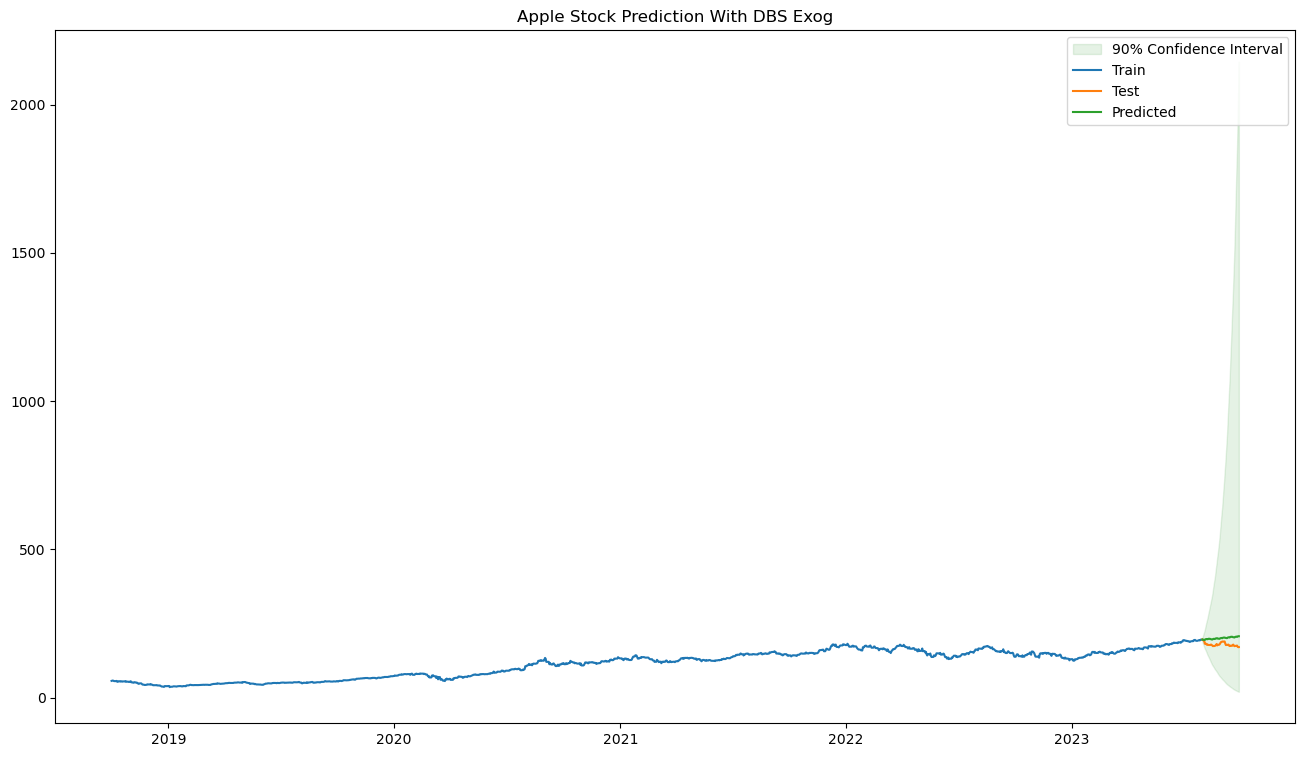

In [374]:
# Splitting the dataset for prediction
df_apple_train_data_unmodified = df['Apple'].iloc[:len(df['Apple'])-60]
df_apple_test_data_unmodified = df['Apple'].iloc[len(df['Apple'])-60:]

# Make predictions
predictions = apple_with_dbs_result.predict(start=len(df_apple_train_data_unmodified)-1, 
                                            end=len(df_apple_train_data_unmodified)+58, exog=exog_dataset[['DBS']][len(df_apple)-60:])

forecast_ci = apple_with_dbs_result.get_prediction(start=len(df_apple_train_data_unmodified)-1, 
                                            end=len(df_apple_train_data_unmodified)+58, exog=exog_dataset[['DBS']][len(df_apple)-60:]).summary_frame(alpha=0.1)

# Compare predictions with actual data
plt.figure(figsize=(16,9))
last_observed_value = df_apple_train_data_unmodified.iloc[-1]
forecast_original = np.cumsum(np.insert(predictions, 0, np.log(last_observed_value)))[1:]
forecast_ci['mean_ci_lower'] = np.cumsum(np.insert(forecast_ci['mean_ci_lower'], 0, np.log(last_observed_value)))[1:]
forecast_ci['mean_ci_upper'] = np.cumsum(np.insert(forecast_ci['mean_ci_upper'], 0, np.log(last_observed_value)))[1:]

plt.fill_between(forecast_ci.index, np.exp(forecast_ci['mean_ci_lower']), np.exp(forecast_ci['mean_ci_upper']), color='green', alpha=0.1, label='90% Confidence Interval')
plt.plot(df_apple_train_data_unmodified.index, df_apple_train_data_unmodified, label='Train')
plt.plot(df_apple_test_data_unmodified.index, df_apple_test_data_unmodified, label='Test')
plt.plot(predictions.index, np.exp(forecast_original), label='Predicted')

plt.title('Apple Stock Prediction With DBS Exog')
plt.legend()
plt.show()

#### 4.3 DBS

In [375]:
print(f"MSE for DBS with Apple as exog: {dbs_with_apple['mse']}")
print(f"MSE for DBS with Amazon as exog: {dbs_with_amazon['mse']}")
print(f"MSE for DBS with Apple and Amazon as exog: {dbs_with_amazon_and_apple['mse']}")

MSE for DBS with Apple as exog: 0.3661931744642695
MSE for DBS with Amazon as exog: 0.6697769346254042
MSE for DBS with Apple and Amazon as exog: 0.38920204255810736


As we can see, the MSE for DBS with Apple as the exog is the lowest. Therefore that model has the best tuned hyperparameters

In [381]:
print(f"Best AIC: {dbs_with_apple['best_aic']}")
print(f"Best Order: {dbs_with_apple['best_order']}")
print(f"Best Seasonal Order: {dbs_with_apple['best_seasonal_order']}")
print(f"MSE: {dbs_with_apple['mse']}")

Best AIC: -10910.141212243274
Best Order: (0, 0, 0)
Best Seasonal Order: (0, 1, 2, 12)
MSE: 0.3661931744642695


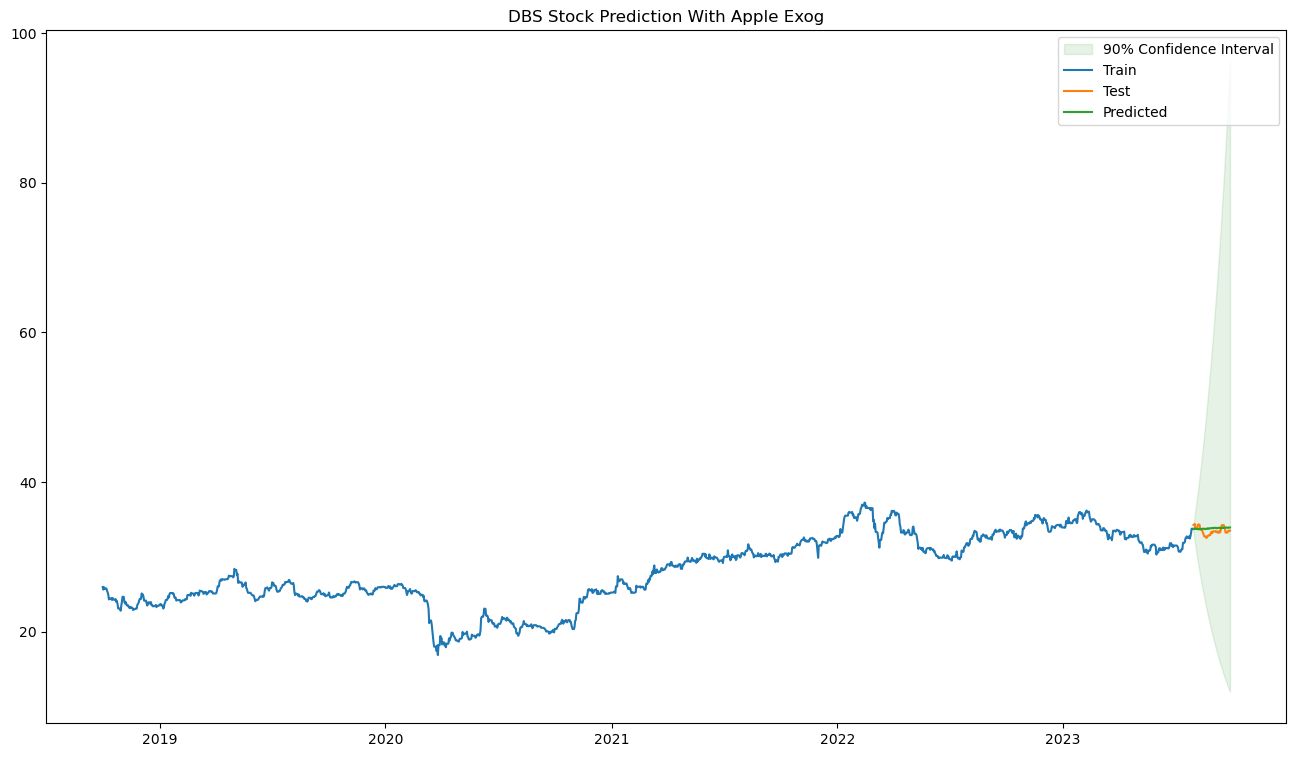

In [376]:
# Splitting the dataset for prediction
df_dbs_train_data_unmodified = df['DBS'].iloc[:len(df['DBS'])-60]
df_dbs_test_data_unmodified = df['DBS'].iloc[len(df['DBS'])-60:]

# Make predictions
predictions = dbs_with_apple_result.predict(start=len(df_dbs_train_data_unmodified)-1, 
                                            end=len(df_dbs_train_data_unmodified)+58, exog=exog_dataset[['Apple']][len(df_dbs)-60:])

forecast_ci = dbs_with_apple_result.get_prediction(start=len(df_dbs_train_data_unmodified)-1, 
                                            end=len(df_dbs_train_data_unmodified)+58, exog=exog_dataset[['Apple']][len(df_dbs)-60:]).summary_frame(alpha=0.1)

# Compare predictions with actual data
plt.figure(figsize=(16,9))
last_observed_value = df_dbs_train_data_unmodified.iloc[-1]
forecast_original = np.cumsum(np.insert(predictions, 0, np.log(last_observed_value)))[1:]
forecast_ci['mean_ci_lower'] = np.cumsum(np.insert(forecast_ci['mean_ci_lower'], 0, np.log(last_observed_value)))[1:]
forecast_ci['mean_ci_upper'] = np.cumsum(np.insert(forecast_ci['mean_ci_upper'], 0, np.log(last_observed_value)))[1:]

plt.fill_between(forecast_ci.index, np.exp(forecast_ci['mean_ci_lower']), np.exp(forecast_ci['mean_ci_upper']), color='green', alpha=0.1, label='90% Confidence Interval')
plt.plot(df_dbs_train_data_unmodified.index, df_dbs_train_data_unmodified, label='Train')
plt.plot(df_dbs_test_data_unmodified.index, df_dbs_test_data_unmodified, label='Test')
plt.plot(predictions.index, np.exp(forecast_original), label='Predicted')
plt.title('DBS Stock Prediction With Apple Exog')
plt.legend()
plt.show()

Although you could argue that the predicted line isn't similar to how a stock time series would look like, it still does capture the general trend of the stock across the next 60 days which I think is more important than getting a model which predictions looks like how a stock would look like but shows an incorrect trend.